In [14]:
# Re-import libraries with GradientBoostingClassifier added
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
# ✅ Add GradientBoostingClassifier here (previously missing)
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier, 
                             GradientBoostingRegressor, GradientBoostingClassifier)
from sklearn.metrics import (r2_score, mean_squared_error, accuracy_score, 
                             roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

# Keep the same plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('muted')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
# Load raw data (use your file path; ensure Excel is in the correct directory)
raw_data = pd.read_excel("C:/Users/31979/Desktop/俄罗斯中国留学生饮食习惯变化.xlsx")

# Print basic info to confirm loading
print("=== Data Loading Confirmation ===")
print(f"Total samples: {raw_data.shape[0]}, Total columns: {raw_data.shape[1]}")
print(f"\nFirst 5 actual column names (from your Excel):")
for i, col in enumerate(raw_data.columns[:5], 1):  # Show first 5 to verify
    print(f"{i}. '{col}'")

# Preview first 2 rows to check data format
print(f"\nFirst 2 rows of data (preview):")
print(raw_data.head(2).iloc[:, :5])  # Show first 5 columns only

=== Data Loading Confirmation ===
Total samples: 62, Total columns: 122

First 5 actual column names (from your Excel):
1. '序号'
2. '提交答卷时间'
3. '所用时间'
4. '来源'
5. '来源详情'

First 2 rows of data (preview):
   序号             提交答卷时间  所用时间    来源  来源详情
0   1  2023/3/13 2:00:22  307秒    微信   NaN
1   2  2023/3/13 2:13:07  347秒  手机提交  直接访问


In [3]:
# Recoding Rules: 
# Key = EXACT column name from your Excel
# Value = {Numerical Code: Meaning (for interpretation)}
encoding_rules = {
    # ---------------------- Demographic Variables (人口统计学) ----------------------
    "1、您来自中国的哪里？\n（南方：海南、台湾、西藏、湖南、湖北、广东、广西、浙江、江苏、安徽、福建、江西、云南、贵州、四川、重庆、上海、香港、澳门；\n北方：北京、天津、内蒙古、新疆、青海、山西、河南、河北、黑龙江、辽宁、吉林、甘肃、宁夏、陕西）\n": 
    {1: 'North China', 2: 'South China'},  # 1=北方, 2=南方（匹配你数据中的编码）
    
    "2、您的性别是？": 
    {1: 'Male', 2: 'Female'},  # 1=男, 2=女
    
    "3、目前所处于的大学课程": 
    {1: 'Undergrad Y1-Y2', 2: 'Undergrad Y3-Y4', 3: 'Master', 4: 'PhD', 6: 'Exchange', 7: 'Other'},  # 覆盖数据中出现的6/7等编码
    
    "4、您在俄罗斯住了多久？": 
    {1: 'Less than 1 year', 2: '1-2 years', 3: '2-3 years', 4: 'More than 3 years'},  # 1=不到1年...
    
    # ---------------------- Dietary Change & Adaptation (饮食变化与适应) ----------------------
    "15、您认为你搬到俄罗斯后，你的饮食结构发生了变化吗？": 
    {1: 'No Change', 2: 'Small Change', 3: 'Moderate Change', 4: 'Large Change', 5: 'Very Large Change'},  # 变化程度
    
    "17、您是否同意这些变化是积极的？": 
    {1: 'Strongly Disagree', 2: 'Disagree', 3: 'Neutral', 4: 'Agree', 5: 'Strongly Agree'},  # 积极态度
    
    "21、来到俄罗斯之后，您用多长时间习惯俄罗斯的饮食？": 
    {1: 'Less than 1 month', 2: '1-2 months', 3: '2-3 months', 4: '3-6 months', 5: 'More than 6 months'},  # 适应时间
    
    "22、您在吃俄罗斯食物一段时间后体重的变化？": 
    {1: 'Significant Loss', 2: 'Minor Loss', 3: 'No Change', 4: 'Minor Gain', 5: 'Significant Gain'},  # 体重变化
    
    # ---------------------- Consumption Comparison (中俄消费对比) ----------------------
    "27、搬到俄罗斯后，菜肴的辣度发生了变化吗？": 
    {1: 'Significant Decrease', 2: 'Minor Decrease', 3: 'No Change', 4: 'Minor Increase', 5: 'Significant Increase'},  # 辣度变化
    
    "29、与在中国相比，你是否在俄罗斯更多的食用蔬菜？": 
    {1: 'Significant Decrease', 2: 'Minor Decrease', 3: 'No Change', 4: 'Minor Increase', 5: 'Significant Increase'},  # 蔬菜消费
    
    "30、与在中国相比，你是否在俄罗斯更多的食用肉类菜肴？": 
    {1: 'Significant Decrease', 2: 'Minor Decrease', 3: 'No Change', 4: 'Minor Increase', 5: 'Significant Increase'},  # 肉类消费
    
    "32、与在中国相比，你是否在俄罗斯食用更多的鱼类和海鲜？": 
    {1: 'Significant Decrease', 2: 'Minor Decrease', 3: 'No Change', 4: 'Minor Increase', 5: 'Significant Increase'},  # 海鲜消费
    
    "31、与在中国相比，你是否在俄罗斯更多的食用快餐？": 
    {1: 'Significant Decrease', 2: 'Minor Decrease', 3: 'No Change', 4: 'Minor Increase', 5: 'Significant Increase'},  # 快餐消费
    
    # ---------------------- Daily Dietary Habits (日常饮食习惯) ----------------------
    "8、(蔬菜的摄入量少)":  # 中国饮食习惯：蔬菜摄入少
    {0: 'No', 1: 'Yes'},  # 0=否, 1=是（二进制编码）
    
    "8、(肉类摄入量大)":  # 中国饮食习惯：肉类摄入大
    {0: 'No', 1: 'Yes'},
    
    "60、(每天食用蔬菜)":  # 俄罗斯饮食习惯：每天吃蔬菜
    {0: 'No', 1: 'Yes'},
    
    "60、(每天食用水果)":  # 俄罗斯饮食习惯：每天吃水果
    {0: 'No', 1: 'Yes'},
    
    "60、(每天食用肉类)":  # 俄罗斯饮食习惯：每天吃肉类
    {0: 'No', 1: 'Yes'},
    
    "60、(每天喝八杯水)":  # 俄罗斯饮食习惯：每天喝8杯水
    {0: 'No', 1: 'Yes'}
}

# ---------------------- Chinese-to-English Column Mapping (中文列名转英文) ----------------------
# Key = EXACT Excel column name (same as above)
# Value = Standard English name (for modeling/visualization)
cn_en_mapping = {
    # Demographics
    "1、您来自中国的哪里？\n（南方：海南、台湾、西藏、湖南、湖北、广东、广西、浙江、江苏、安徽、福建、江西、云南、贵州、四川、重庆、上海、香港、澳门；\n北方：北京、天津、内蒙古、新疆、青海、山西、河南、河北、黑龙江、辽宁、吉林、甘肃、宁夏、陕西）\n": "Region",
    "2、您的性别是？": "Gender",
    "3、目前所处于的大学课程": "Academic_Grade",
    "4、您在俄罗斯住了多久？": "Russia_Stay_Duration",
    
    # Dietary Change & Adaptation
    "15、您认为你搬到俄罗斯后，你的饮食结构发生了变化吗？": "Diet_Structure_Change",
    "17、您是否同意这些变化是积极的？": "Positive_Change_Attitude",
    "21、来到俄罗斯之后，您用多长时间习惯俄罗斯的饮食？": "Diet_Adaptation_Time",
    "22、您在吃俄罗斯食物一段时间后体重的变化？": "Weight_Change",
    
    # Consumption Comparison
    "27、搬到俄罗斯后，菜肴的辣度发生了变化吗？": "Spicy_Level_Change",
    "29、与在中国相比，你是否在俄罗斯更多的食用蔬菜？": "Vegetable_Consumption_Change",
    "30、与在中国相比，你是否在俄罗斯更多的食用肉类菜肴？": "Meat_Consumption_Change",
    "32、与在中国相比，你是否在俄罗斯食用更多的鱼类和海鲜？": "Seafood_Consumption_Change",
    "31、与在中国相比，你是否在俄罗斯更多的食用快餐？": "Fastfood_Consumption_Change",
    
    # Daily Habits
    "8、(蔬菜的摄入量少)": "China_Vegetable_Low",
    "8、(肉类摄入量大)": "China_Meat_High",
    "60、(每天食用蔬菜)": "Russia_Vegetable_Daily",
    "60、(每天食用水果)": "Russia_Fruit_Daily",
    "60、(每天食用肉类)": "Russia_Meat_Daily",
    "60、(每天喝八杯水)": "Russia_Water_Daily"
}

In [4]:
# Step 1: Select core columns (only those in encoding_rules)
core_excel_cols = list(encoding_rules.keys())
data_clean = raw_data[core_excel_cols].copy()  # No KeyError now (exact match)

# Step 2: Handle missing/invalid values (e.g., "-3" in your data = invalid)
# Replace "-3" with NaN, then fill missing values
for col in data_clean.columns:
    # Convert "-3" (invalid) to NaN
    data_clean[col] = data_clean[col].replace(-3, np.nan)
    
    # Fill missing values: median for numerical, mode for categorical
    if data_clean[col].dtype in ['int64', 'float64']:
        data_clean[col].fillna(data_clean[col].median(), inplace=True)
    else:
        data_clean[col].fillna(data_clean[col].mode()[0], inplace=True)

# Step 3: Enforce ordinal coding (convert text/values to 1-5 scale)
def apply_exact_coding(df, rules):
    df_encoded = df.copy()
    for excel_col, code_map in rules.items():
        if excel_col in df_encoded.columns:
            # Reverse mapping: convert labels to numerical codes (1-5)
            label_to_code = {label: code for code, label in code_map.items()}
            
            # Convert values to standard codes
            df_encoded[excel_col] = df_encoded[excel_col].apply(
                lambda x: label_to_code[x] if x in label_to_code else x
            )
            
            # Ensure all values are valid (clip outliers to 1-5 if needed)
            df_encoded[excel_col] = pd.to_numeric(df_encoded[excel_col], errors='coerce')
            df_encoded[excel_col] = df_encoded[excel_col].clip(1, 5, axis=0)
    return df_encoded

# Execute coding
data_encoded = apply_exact_coding(data_clean, encoding_rules)

# Step 4: Rename columns to English (for modeling/visualization)
data_final = data_encoded.rename(columns=cn_en_mapping)

# Step 5: Verify preprocessing results
print("\n=== Preprocessing Completed ===")
print(f"Final data shape: {data_final.shape}")
print(f"First 5 rows of processed data (English columns):")
print(data_final.head())
print(f"\nValue range check (all variables: 1-5):")
print(f"Min value: {data_final.min().min()}, Max value: {data_final.max().max()}")


=== Preprocessing Completed ===
Final data shape: (62, 19)
First 5 rows of processed data (English columns):
   Region  Gender  Academic_Grade  Russia_Stay_Duration  \
0       1       1               4                     2   
1       2       2               3                     1   
2       2       1               4                     2   
3       2       2               4                     3   
4       2       1               5                     4   

   Diet_Structure_Change  Positive_Change_Attitude  Diet_Adaptation_Time  \
0                      2                       2.5                     4   
1                      3                       5.0                     1   
2                      3                       1.0                     1   
3                      3                       3.0                     2   
4                      5                       5.0                     4   

   Weight_Change  Spicy_Level_Change  Vegetable_Consumption_Change  \
0       

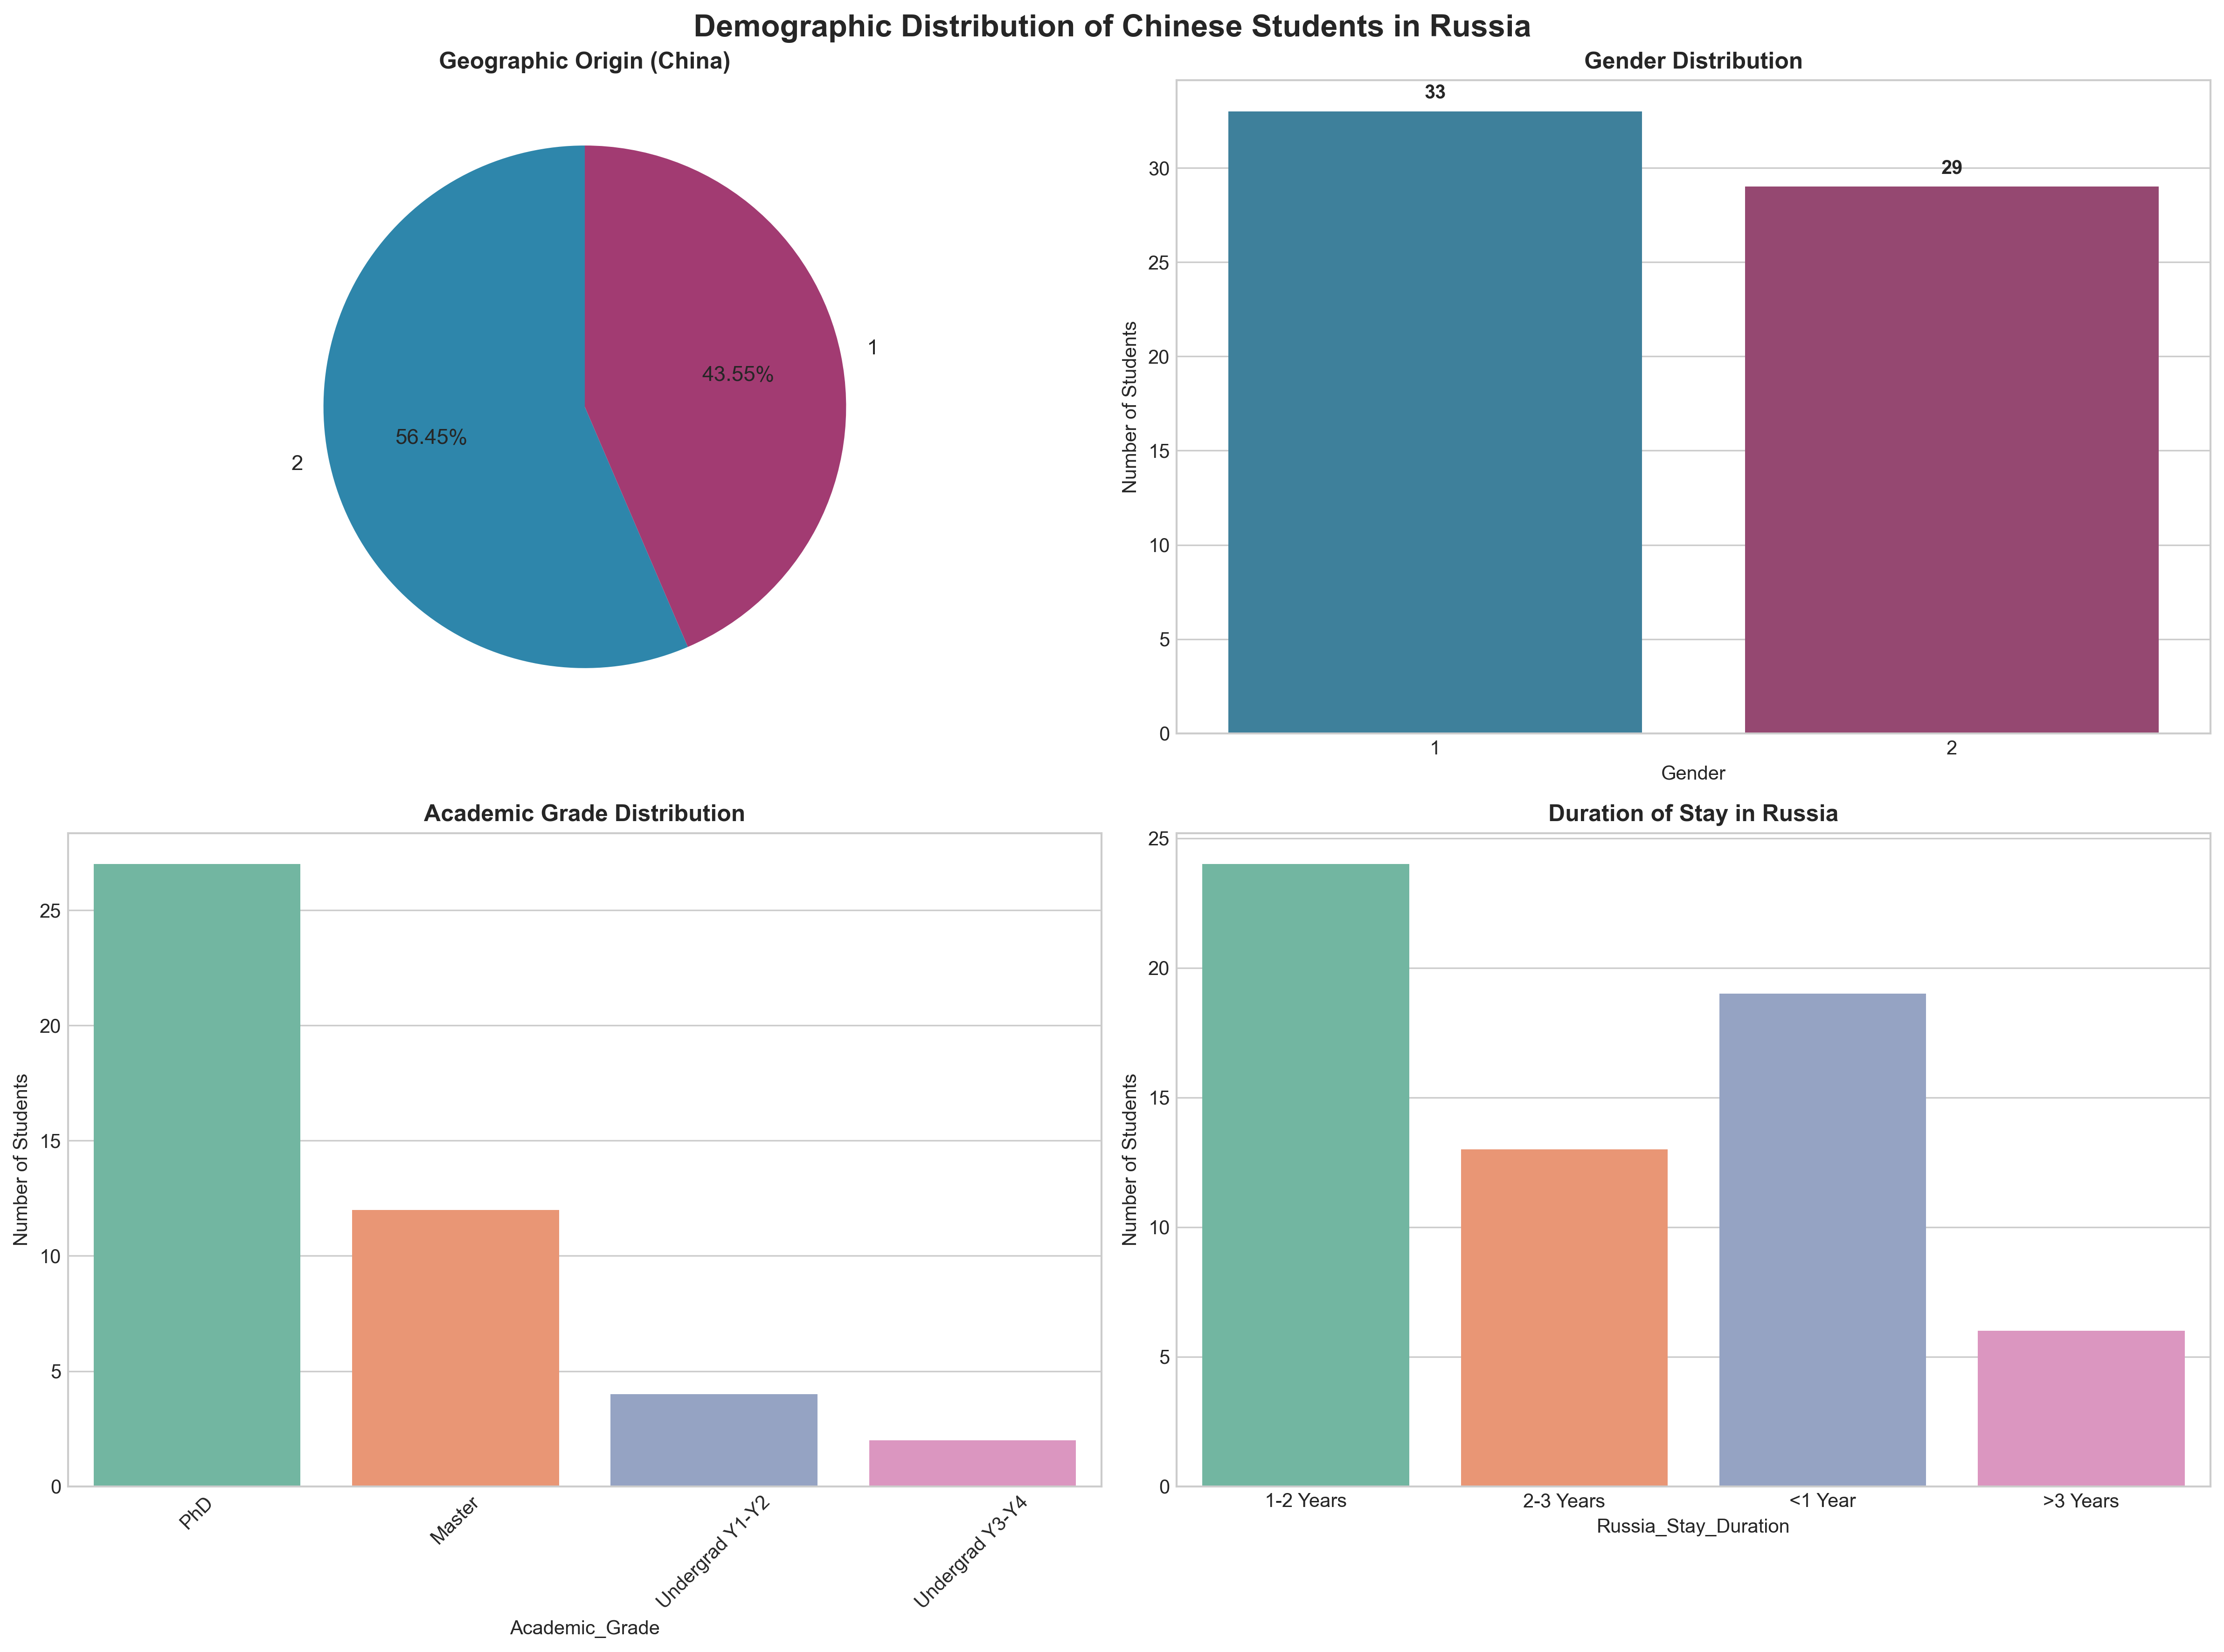

In [5]:
def plot_demographics(data):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Demographic Distribution of Chinese Students in Russia', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Region Distribution (North/South China)
    region_counts = data['Region'].value_counts()
    colors = ['#2E86AB', '#A23B72']
    axes[0,0].pie(region_counts.values, labels=region_counts.index, autopct='%1.2f%%', 
                  colors=colors, startangle=90, textprops={'fontsize': 11})
    axes[0,0].set_title('Geographic Origin (China)', fontsize=12, fontweight='bold')
    
    # 2. Gender Distribution
    gender_counts = data['Gender'].value_counts()
    sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axes[0,1], palette=colors)
    axes[0,1].set_title('Gender Distribution', fontsize=12, fontweight='bold')
    axes[0,1].set_ylabel('Number of Students')
    for i, v in enumerate(gender_counts.values):
        axes[0,1].text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')
    
    # 3. Academic Grade Distribution
    grade_mapping = {1:'Undergrad Y1-Y2', 2:'Undergrad Y3-Y4', 3:'Master', 4:'PhD', 6:'Exchange', 7:'Other'}
    grade_counts = data['Academic_Grade'].map(grade_mapping).value_counts()
    sns.barplot(x=grade_counts.index, y=grade_counts.values, ax=axes[1,0], palette='Set2')
    axes[1,0].set_title('Academic Grade Distribution', fontsize=12, fontweight='bold')
    axes[1,0].set_ylabel('Number of Students')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. Duration in Russia
    duration_mapping = {1:'<1 Year', 2:'1-2 Years', 3:'2-3 Years', 4:'>3 Years'}
    duration_counts = data['Russia_Stay_Duration'].map(duration_mapping).value_counts().sort_index()
    sns.barplot(x=duration_counts.index, y=duration_counts.values, ax=axes[1,1], palette='Set2')
    axes[1,1].set_title('Duration of Stay in Russia', fontsize=12, fontweight='bold')
    axes[1,1].set_ylabel('Number of Students')
    
    plt.tight_layout()
    plt.show()

# Execute plot
plot_demographics(data_final)

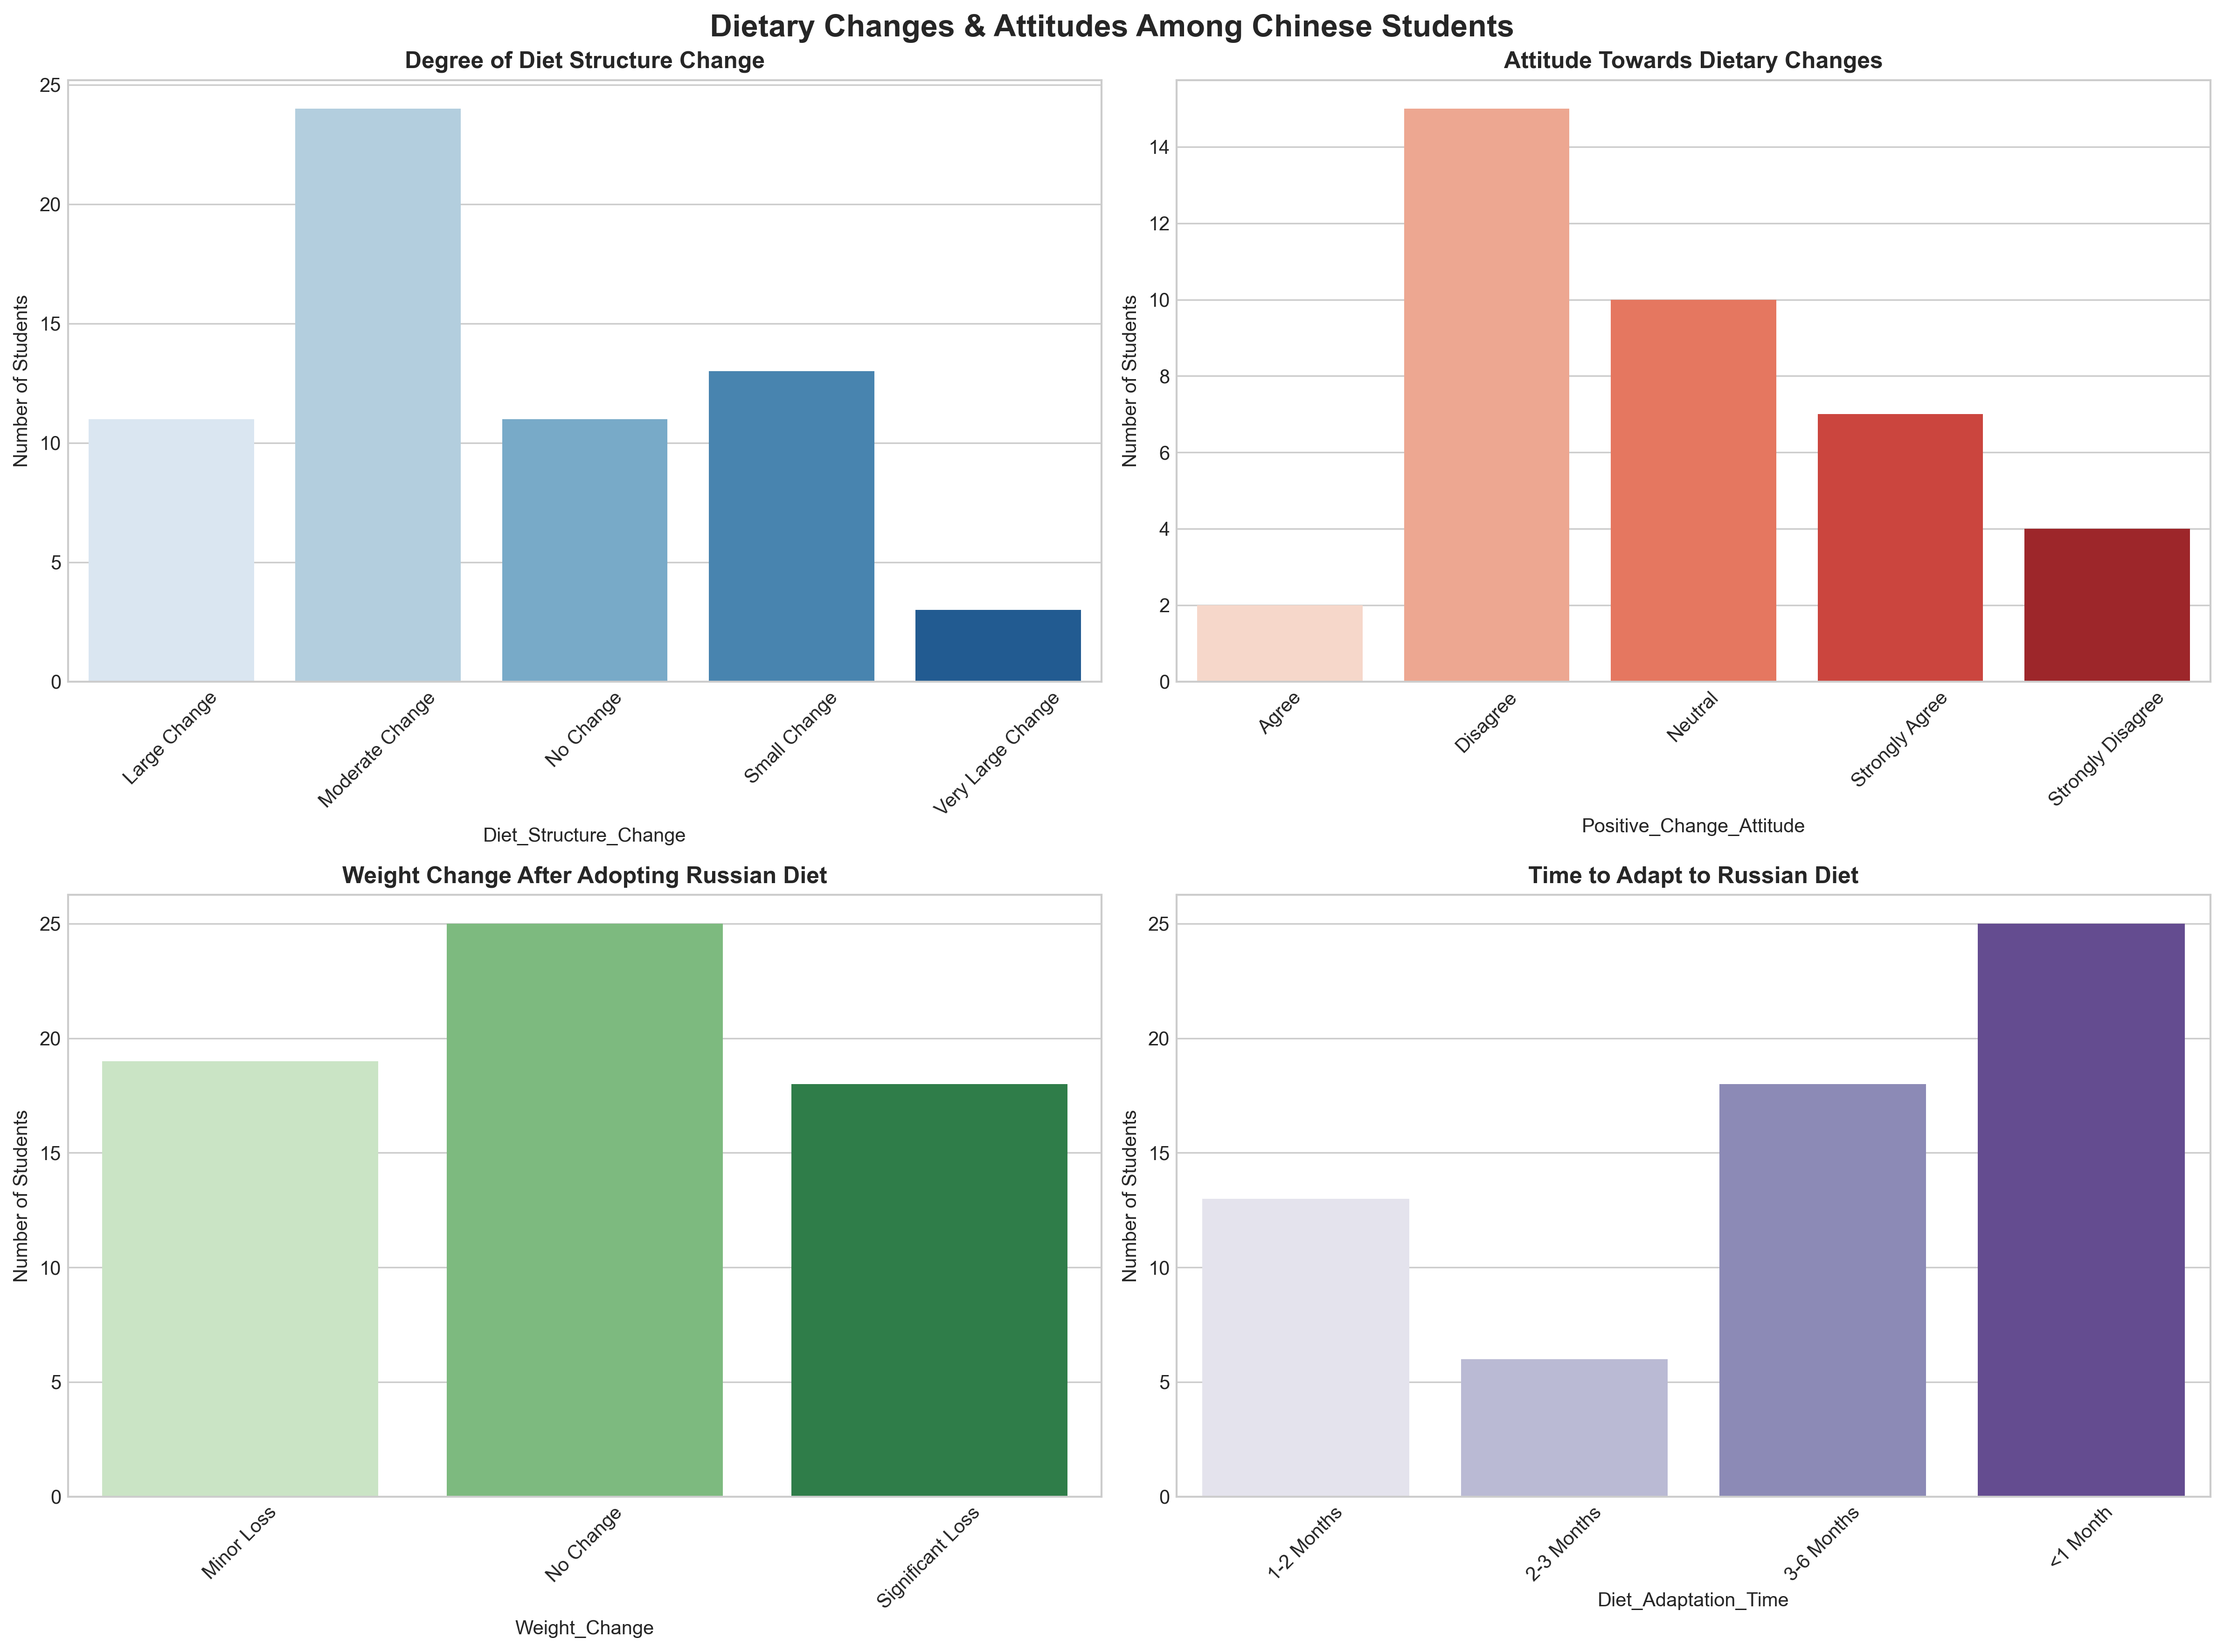

In [6]:
def plot_dietary_changes(data):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Dietary Changes & Attitudes Among Chinese Students', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Diet Structure Change Degree
    change_mapping = {1:'No Change', 2:'Small Change', 3:'Moderate Change', 4:'Large Change', 5:'Very Large Change'}
    change_counts = data['Diet_Structure_Change'].map(change_mapping).value_counts().sort_index()
    sns.barplot(x=change_counts.index, y=change_counts.values, ax=axes[0,0], palette='Blues')
    axes[0,0].set_title('Degree of Diet Structure Change', fontsize=12, fontweight='bold')
    axes[0,0].set_ylabel('Number of Students')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Positive Attitude Towards Changes
    attitude_mapping = {1:'Strongly Disagree', 2:'Disagree', 3:'Neutral', 4:'Agree', 5:'Strongly Agree'}
    attitude_counts = data['Positive_Change_Attitude'].map(attitude_mapping).value_counts().sort_index()
    sns.barplot(x=attitude_counts.index, y=attitude_counts.values, ax=axes[0,1], palette='Reds')
    axes[0,1].set_title('Attitude Towards Dietary Changes', fontsize=12, fontweight='bold')
    axes[0,1].set_ylabel('Number of Students')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Weight Change
    weight_mapping = {1:'Significant Loss', 2:'Minor Loss', 3:'No Change', 4:'Minor Gain', 5:'Significant Gain'}
    weight_counts = data['Weight_Change'].map(weight_mapping).value_counts().sort_index()
    sns.barplot(x=weight_counts.index, y=weight_counts.values, ax=axes[1,0], palette='Greens')
    axes[1,0].set_title('Weight Change After Adopting Russian Diet', fontsize=12, fontweight='bold')
    axes[1,0].set_ylabel('Number of Students')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. Diet Adaptation Time
    adapt_mapping = {1:'<1 Month', 2:'1-2 Months', 3:'2-3 Months', 4:'3-6 Months', 5:'>6 Months'}
    adapt_counts = data['Diet_Adaptation_Time'].map(adapt_mapping).value_counts().sort_index()
    sns.barplot(x=adapt_counts.index, y=adapt_counts.values, ax=axes[1,1], palette='Purples')
    axes[1,1].set_title('Time to Adapt to Russian Diet', fontsize=12, fontweight='bold')
    axes[1,1].set_ylabel('Number of Students')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Execute plot
plot_dietary_changes(data_final)

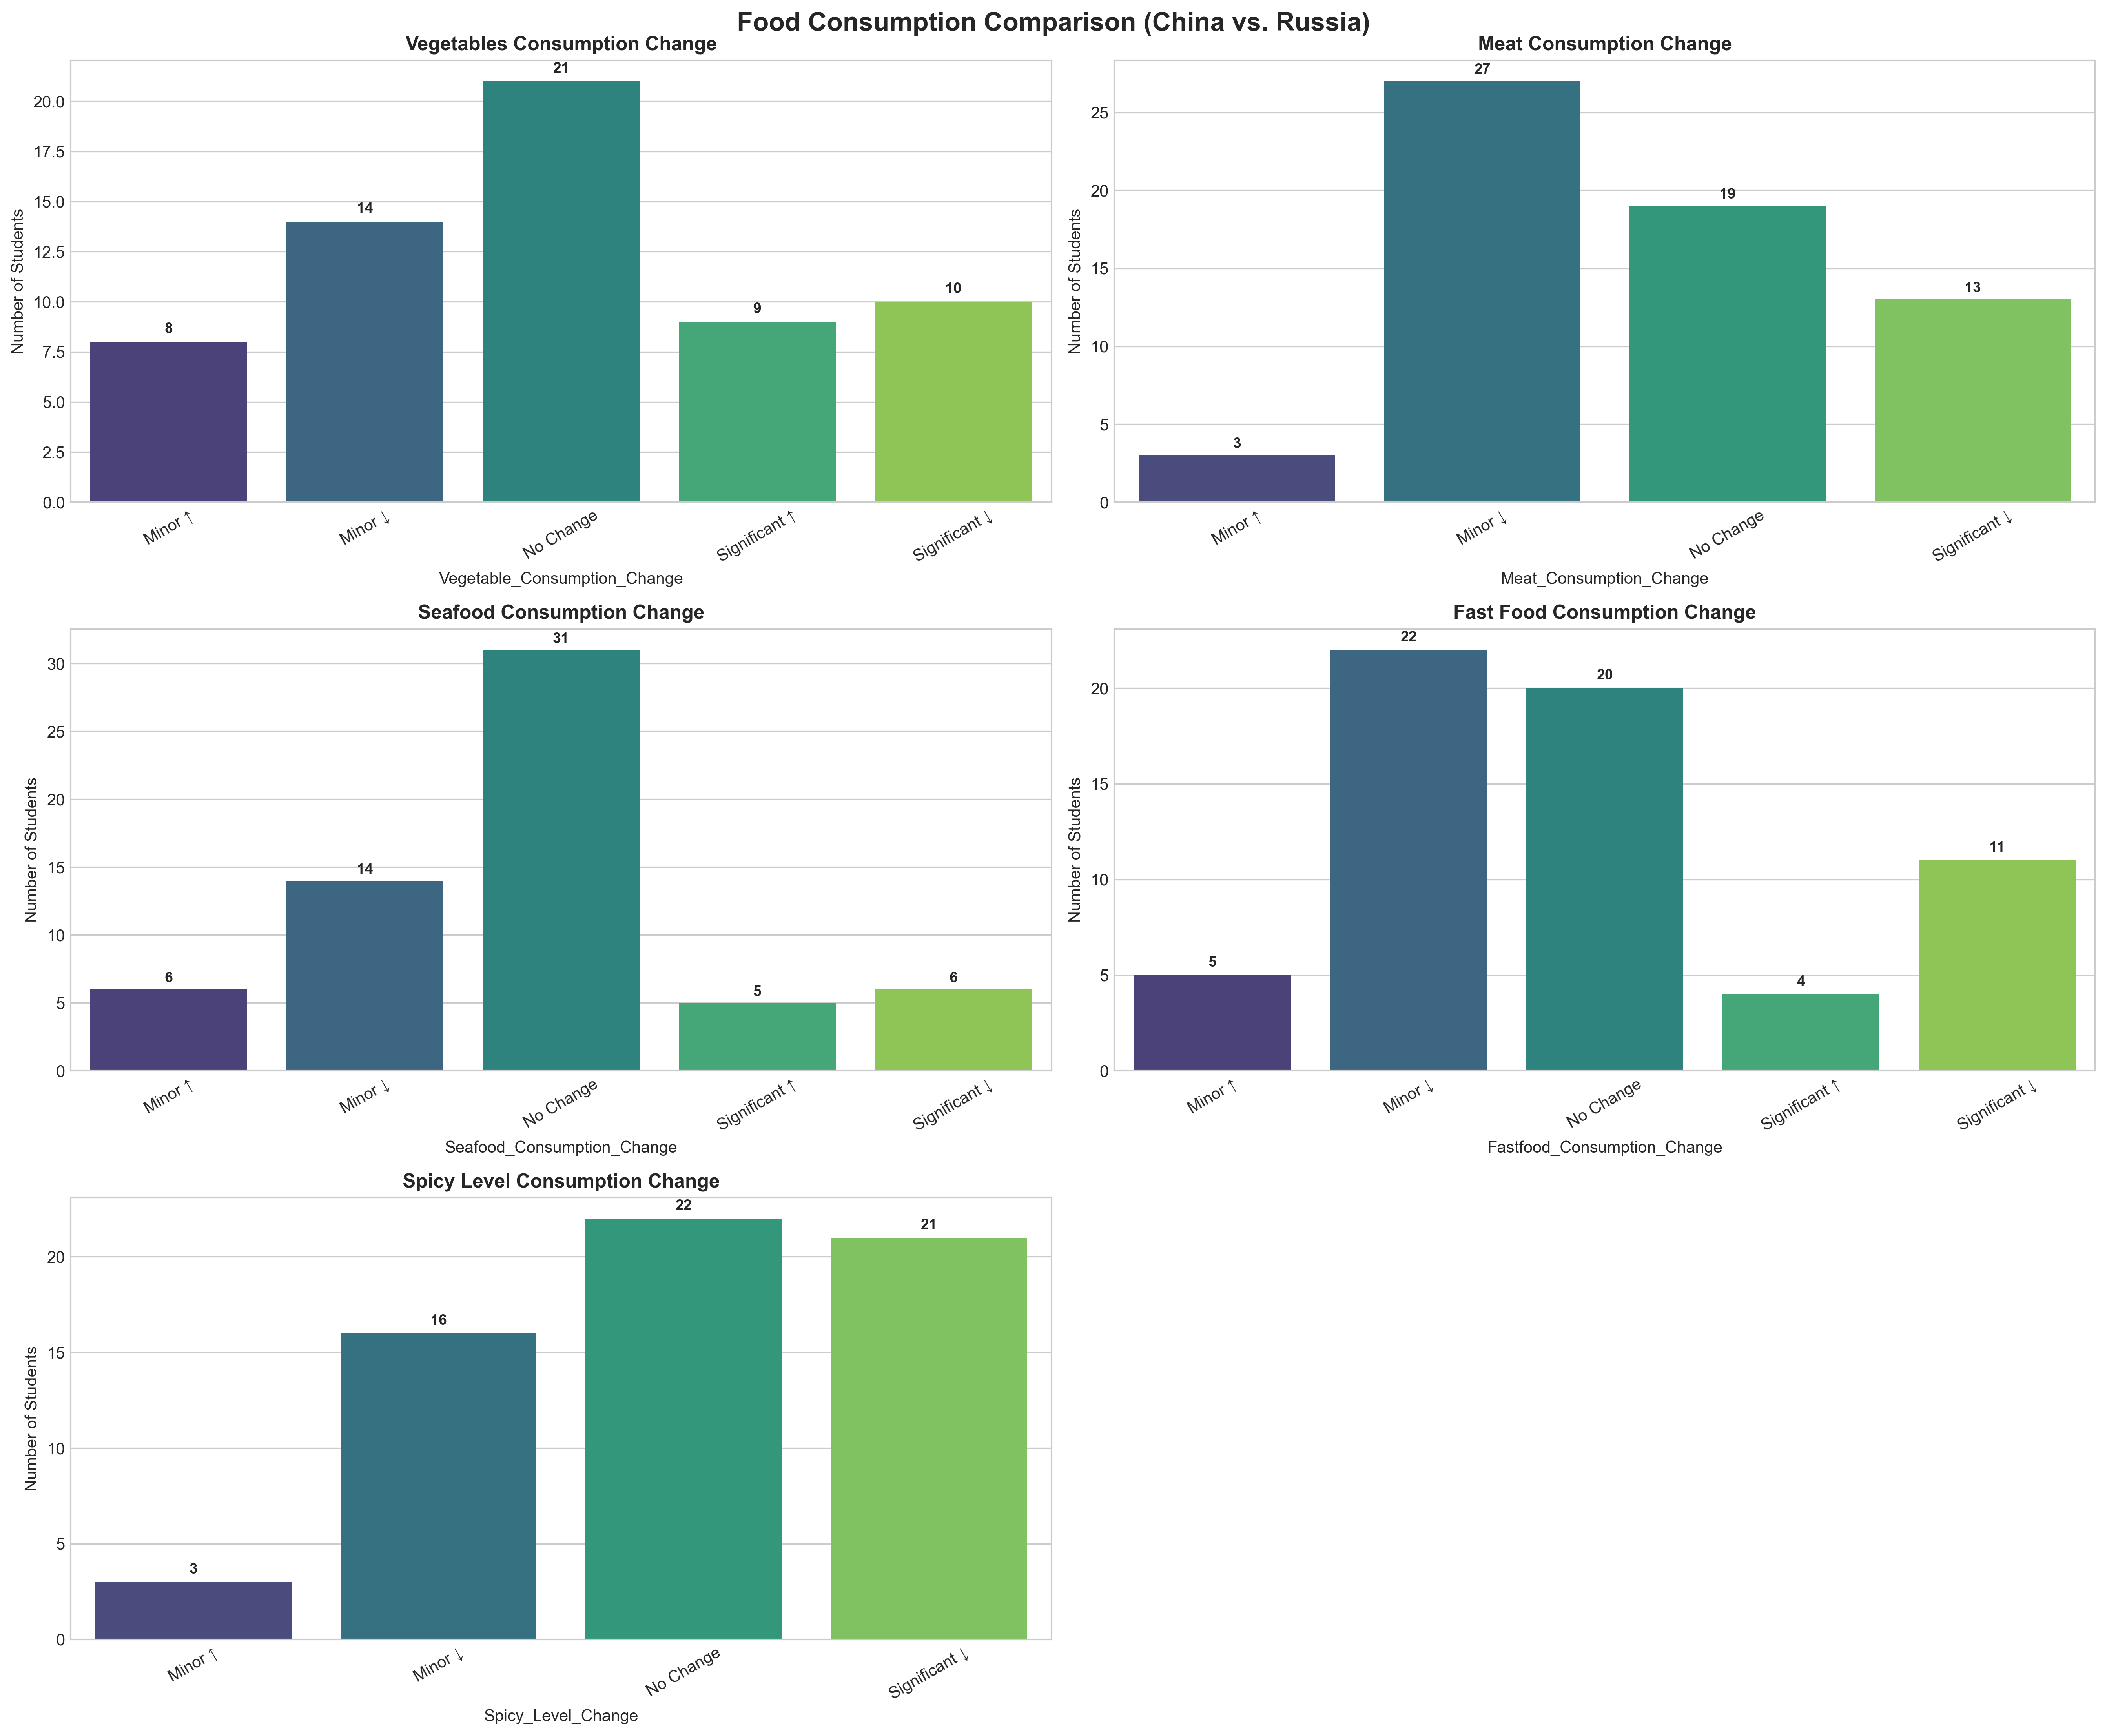

In [7]:
def plot_consumption_comparison(data):
    # Define consumption variables (English names)
    consumption_vars = [
        'Vegetable_Consumption_Change', 'Meat_Consumption_Change',
        'Seafood_Consumption_Change', 'Fastfood_Consumption_Change', 'Spicy_Level_Change'
    ]
    var_labels = ['Vegetables', 'Meat', 'Seafood', 'Fast Food', 'Spicy Level']
    
    # Mapping for consumption change (↓=Decrease, ↑=Increase)
    consumption_mapping = {1:'Significant ↓', 2:'Minor ↓', 3:'No Change', 4:'Minor ↑', 5:'Significant ↑'}
    
    # Create subplots
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    fig.suptitle('Food Consumption Comparison (China vs. Russia)', 
                 fontsize=16, fontweight='bold', y=0.98)
    axes = axes.flatten()
    
    # Plot each consumption variable
    for i, (var, label) in enumerate(zip(consumption_vars, var_labels)):
        if i < len(axes):
            count_data = data[var].map(consumption_mapping).value_counts().sort_index()
            sns.barplot(x=count_data.index, y=count_data.values, ax=axes[i], palette='viridis')
            axes[i].set_title(f'{label} Consumption Change', fontsize=12, fontweight='bold')
            axes[i].set_ylabel('Number of Students')
            axes[i].tick_params(axis='x', rotation=30)
            
            # Add value labels
            for j, v in enumerate(count_data.values):
                axes[i].text(j, v + 0.3, str(v), ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Hide unused subplot
    axes[-1].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Execute plot
plot_consumption_comparison(data_final)

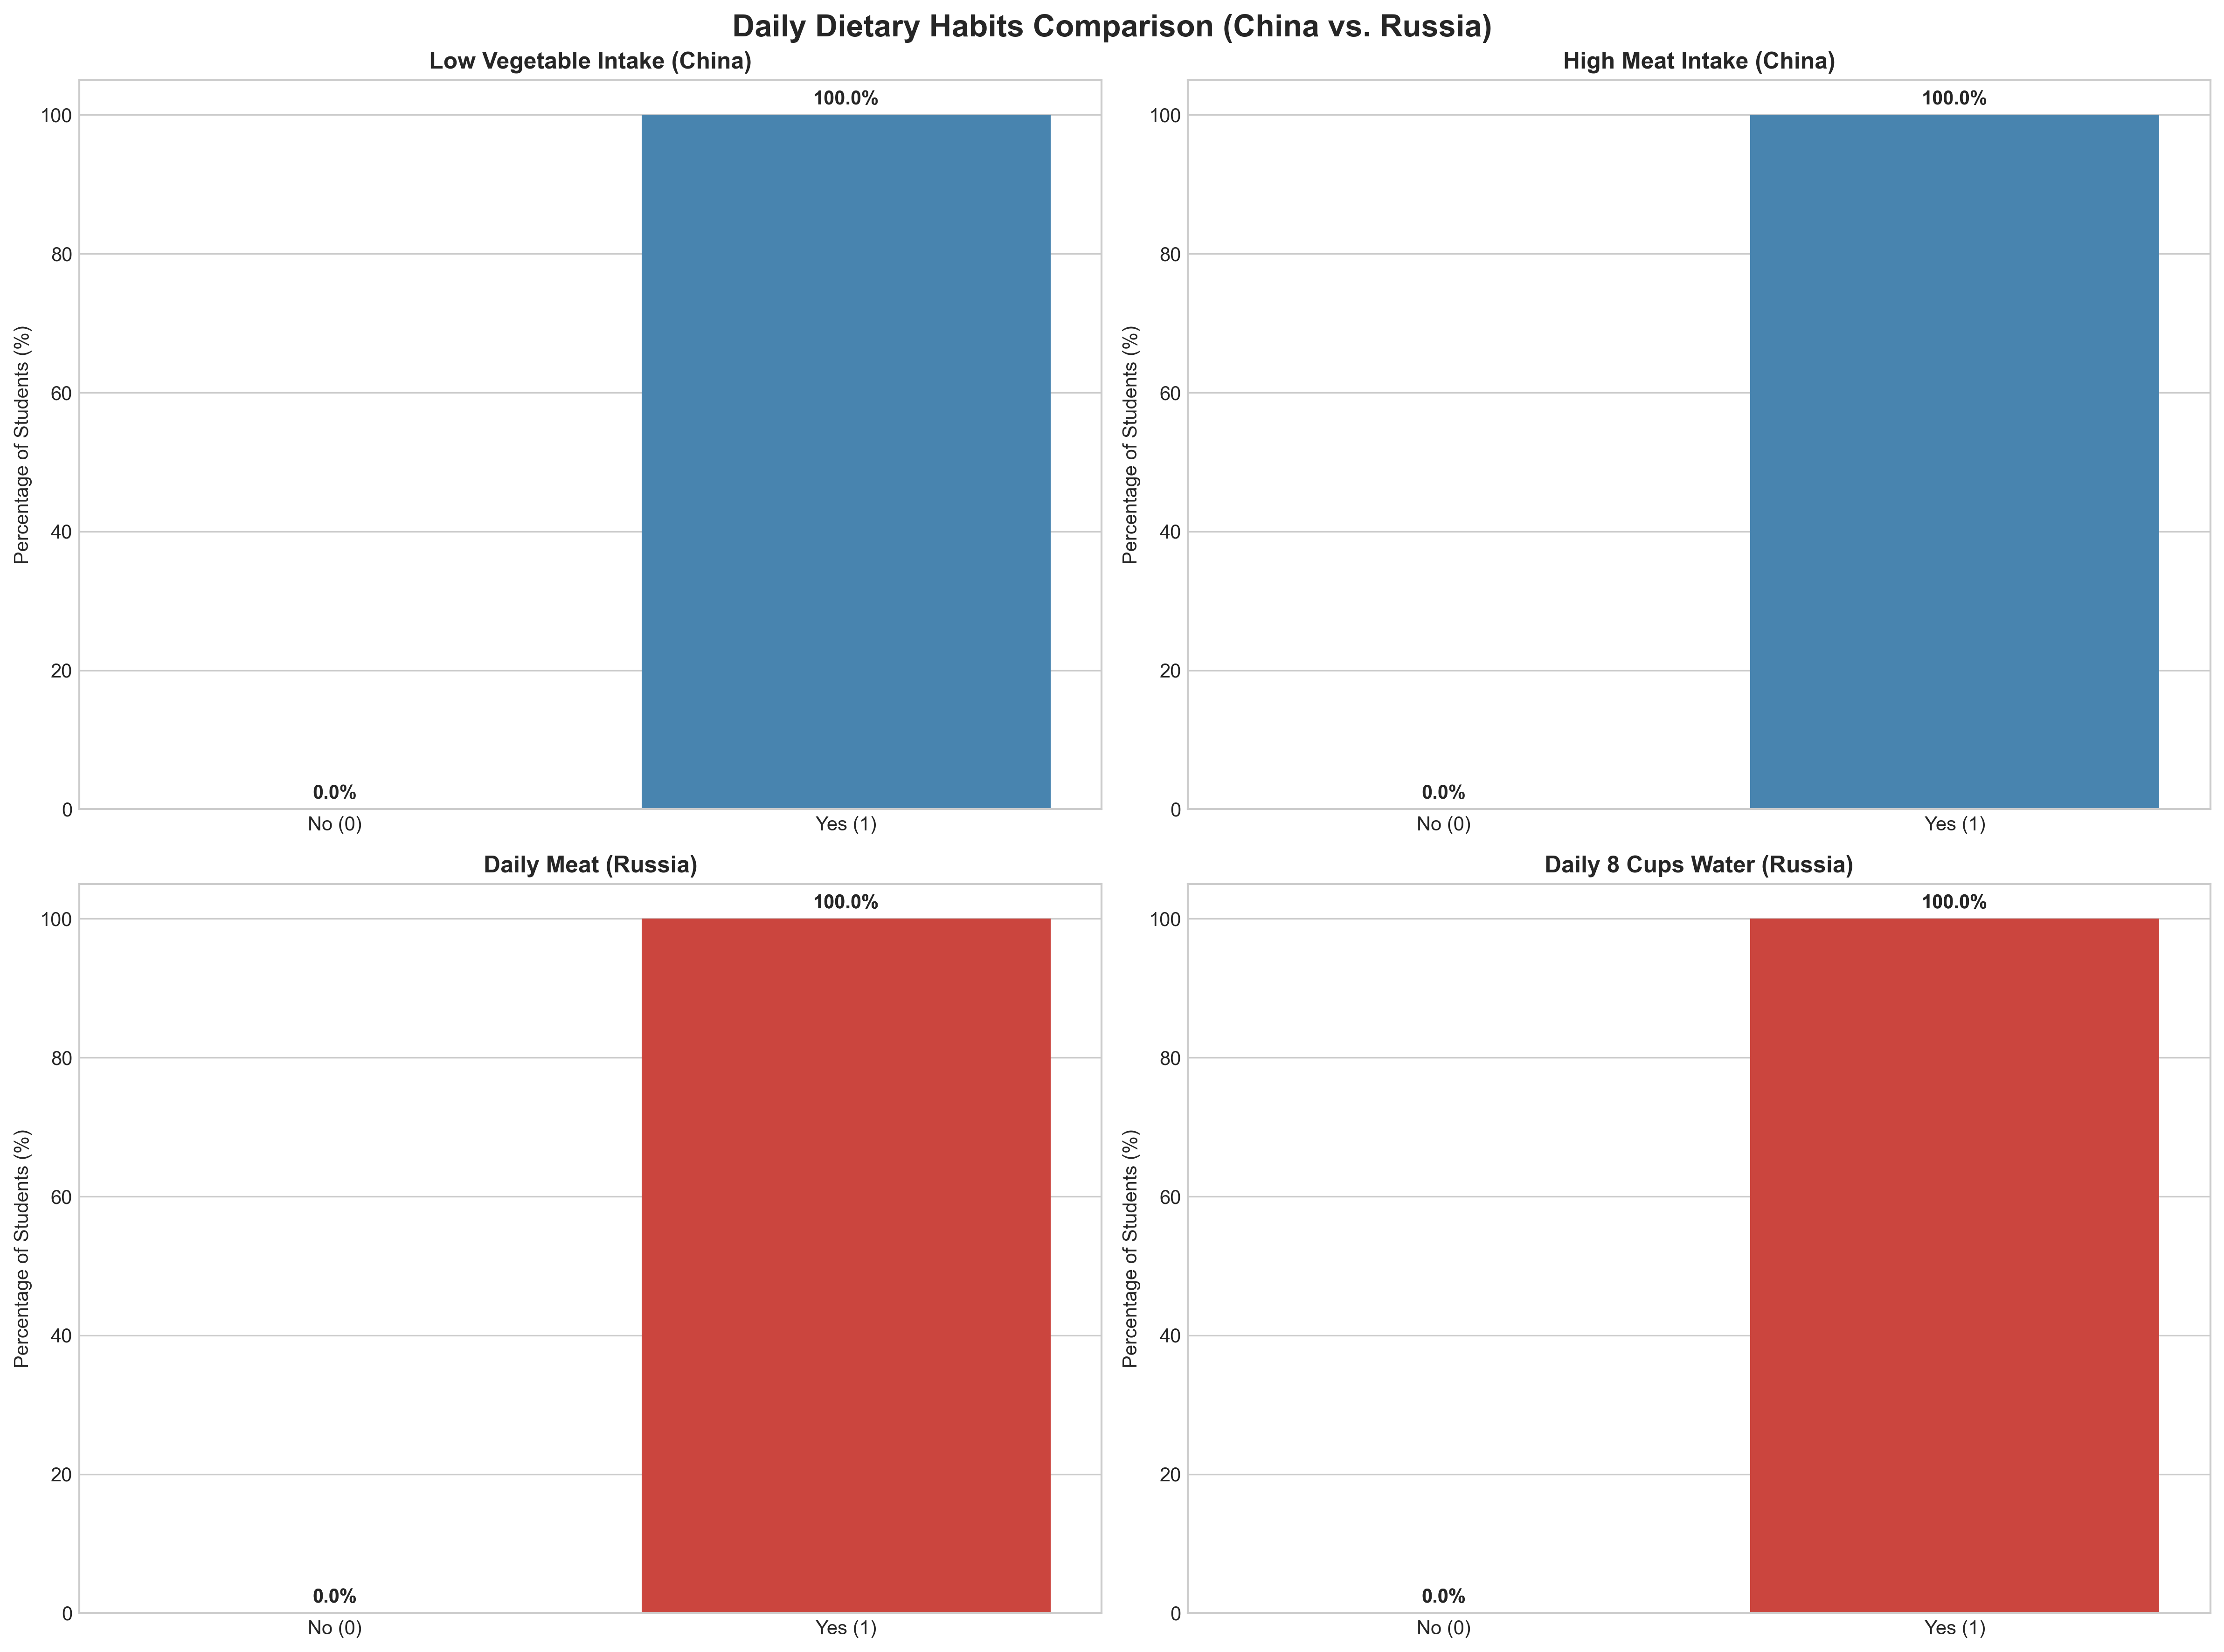

In [8]:
def plot_habits_comparison(data):
    # Habit variables (China vs Russia)
    china_habits = ['China_Vegetable_Low', 'China_Meat_High']
    russia_habits = ['Russia_Vegetable_Daily', 'Russia_Fruit_Daily', 'Russia_Meat_Daily', 'Russia_Water_Daily']
    china_labels = ['Low Vegetable Intake (China)', 'High Meat Intake (China)']
    russia_labels = ['Daily Vegetables (Russia)', 'Daily Fruit (Russia)', 'Daily Meat (Russia)', 'Daily 8 Cups Water (Russia)']
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Daily Dietary Habits Comparison (China vs. Russia)', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Plot China habits (left)
    for i, (var, label) in enumerate(zip(china_habits, china_labels)):
        habit_counts = data[var].value_counts().sort_index()
        habit_pct = (habit_counts / habit_counts.sum()) * 100
        sns.barplot(x=[f'No (0)', f'Yes (1)'], y=[habit_pct.get(0, 0), habit_pct.get(1, 0)], 
                    ax=axes[0, i], palette='Blues')
        axes[0, i].set_title(label, fontsize=12, fontweight='bold')
        axes[0, i].set_ylabel('Percentage of Students (%)')
        # Add percentage labels
        for j, v in enumerate([habit_pct.get(0, 0), habit_pct.get(1, 0)]):
            axes[0, i].text(j, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Plot Russia habits (right)
    for i, (var, label) in enumerate(zip(russia_habits, russia_labels)):
        row, col = 1, i % 2
        habit_counts = data[var].value_counts().sort_index()
        habit_pct = (habit_counts / habit_counts.sum()) * 100
        sns.barplot(x=[f'No (0)', f'Yes (1)'], y=[habit_pct.get(0, 0), habit_pct.get(1, 0)], 
                    ax=axes[row, col], palette='Reds')
        axes[row, col].set_title(label, fontsize=12, fontweight='bold')
        axes[row, col].set_ylabel('Percentage of Students (%)')
        # Add percentage labels
        for j, v in enumerate([habit_pct.get(0, 0), habit_pct.get(1, 0)]):
            axes[row, col].text(j, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Execute plot
plot_habits_comparison(data_final)

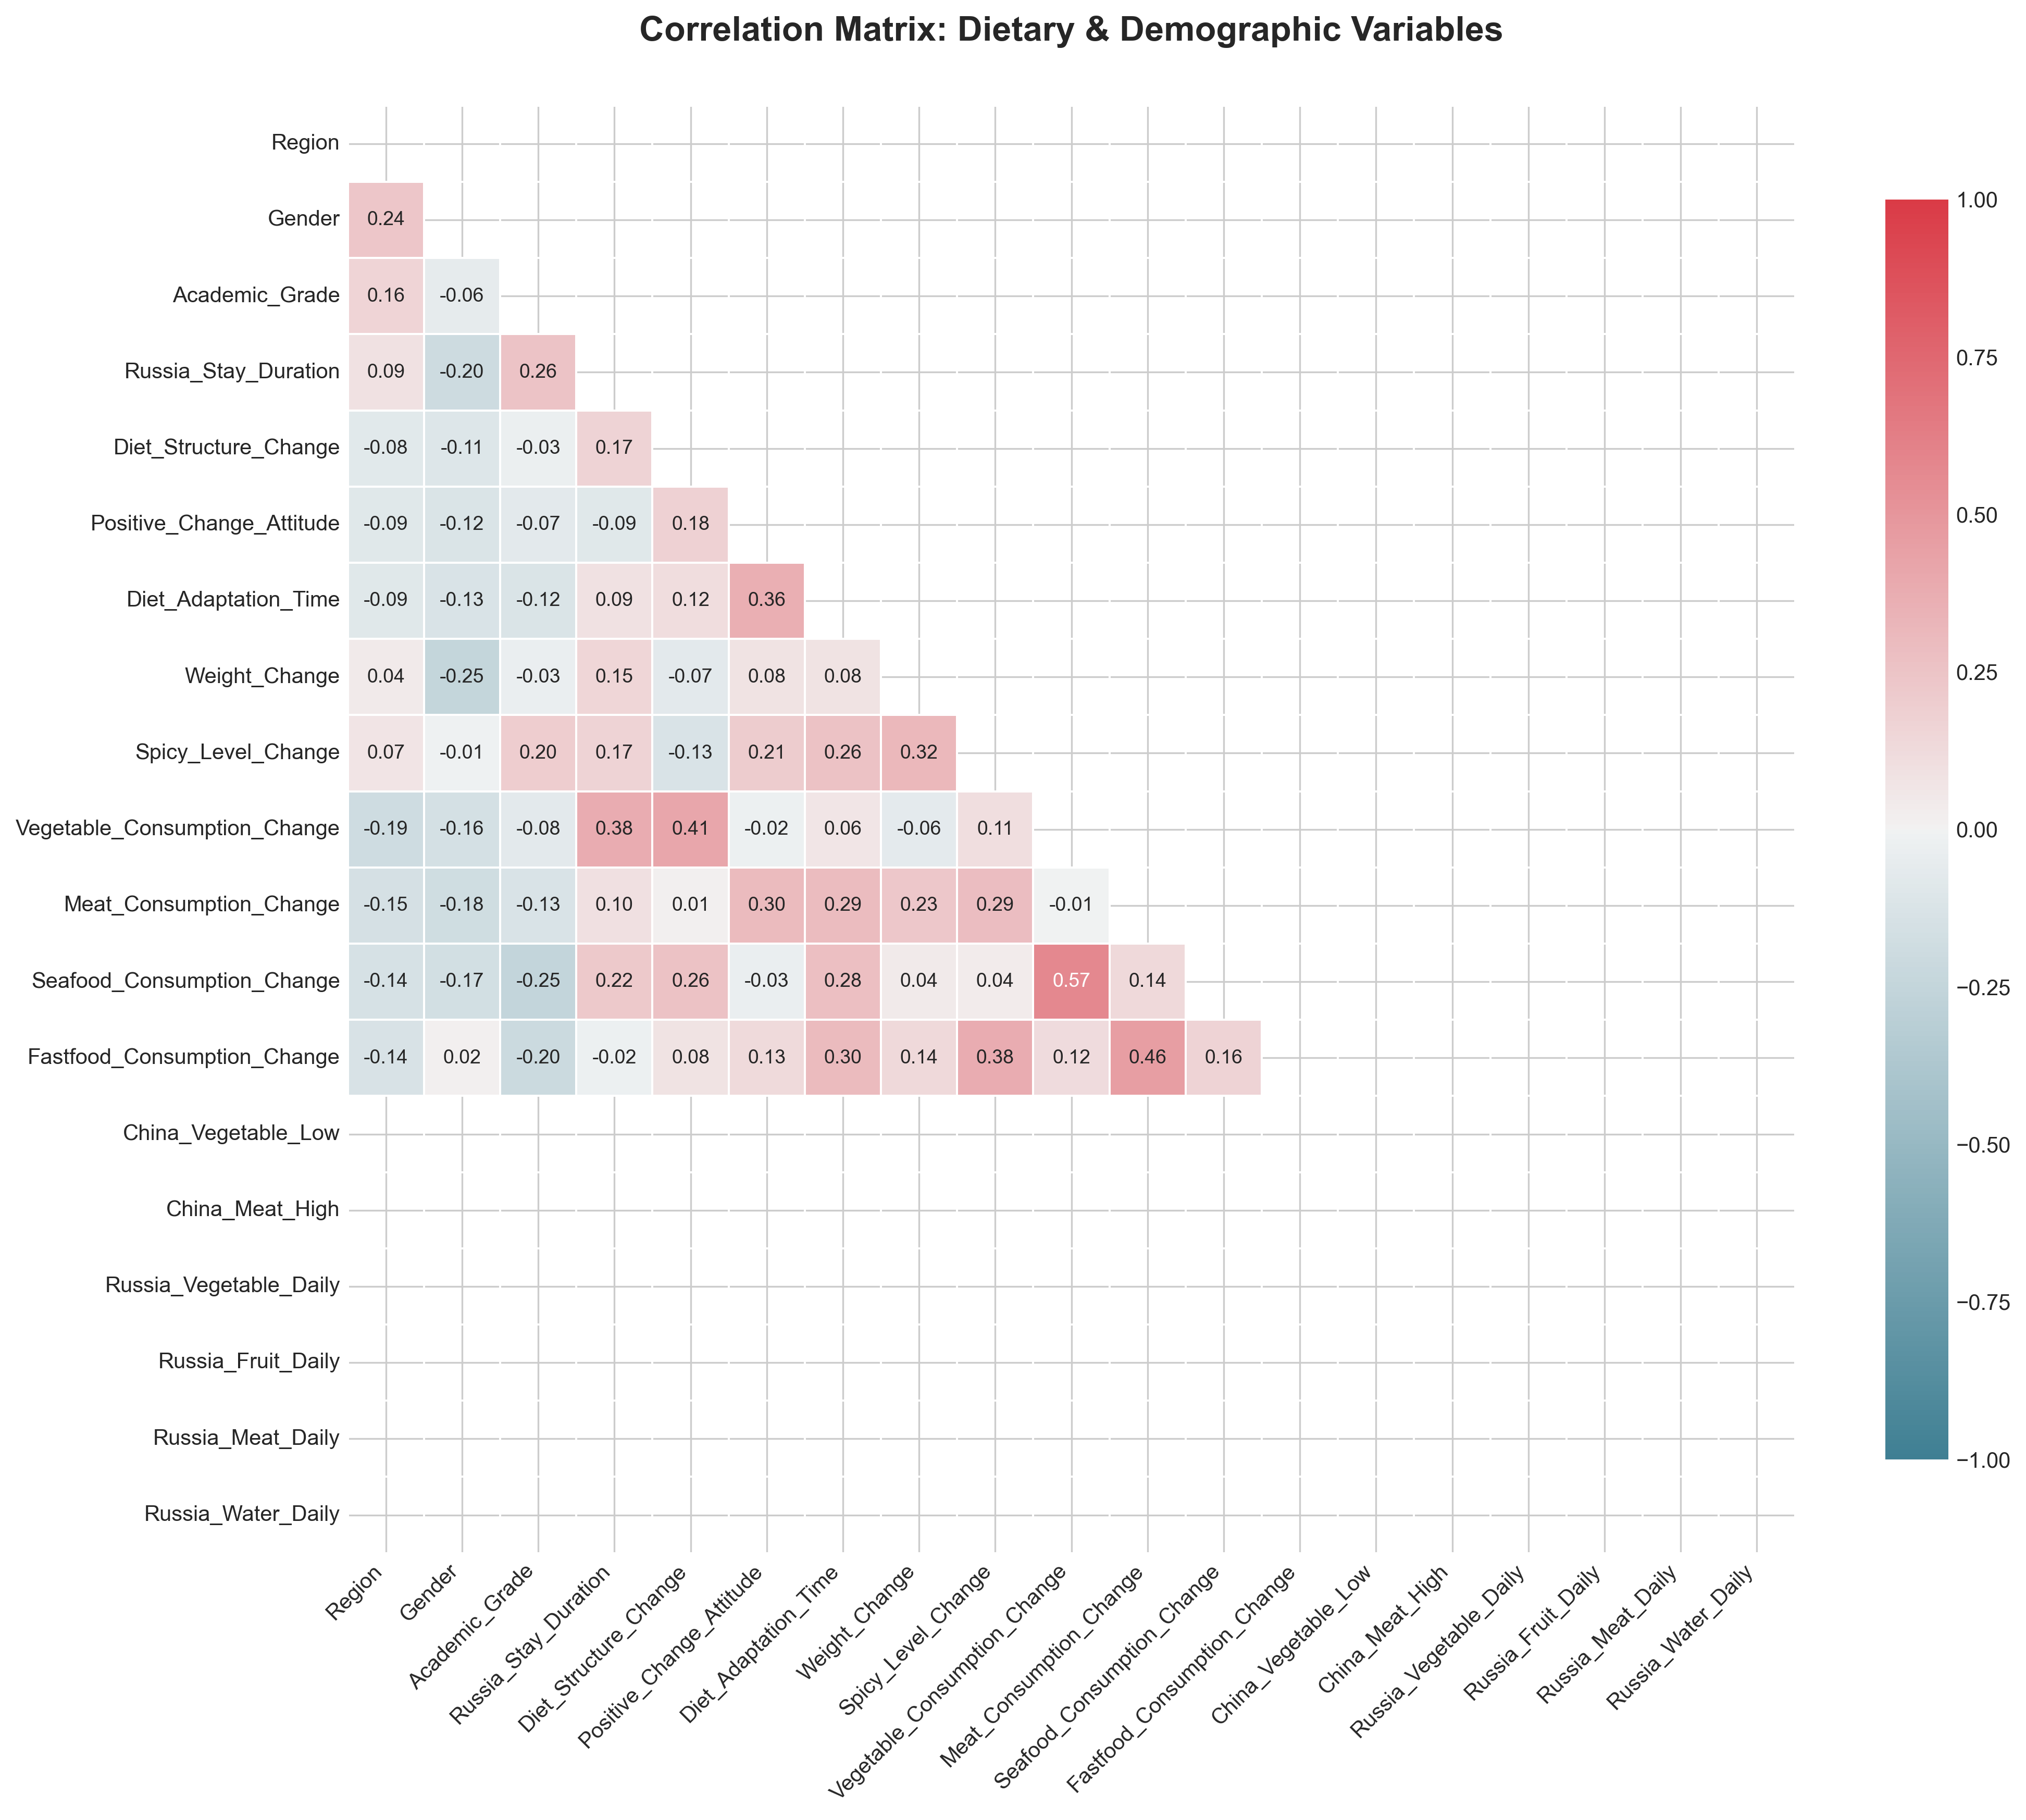

In [9]:
def plot_correlation_matrix(data):
    # Select numerical variables for correlation
    numeric_vars = data.select_dtypes(include=['int64', 'float64']).columns
    corr_matrix = data[numeric_vars].corr()
    
    # Create heatmap with upper triangle masked
    fig, ax = plt.subplots(figsize=(14, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)  # Professional color map
    
    sns.heatmap(
        corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
        square=True, linewidths=.5, annot=True, fmt='.2f', cbar_kws={"shrink": .8},
        annot_kws={'fontsize': 9}
    )
    
    ax.set_title('Correlation Matrix: Dietary & Demographic Variables', 
                 fontsize=16, fontweight='bold', pad=30)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

# Execute plot
plot_correlation_matrix(data_final)

In [10]:
# Define features (X) and targets (y)
# Features: All variables except targets
feature_vars = [
    'Region', 'Gender', 'Academic_Grade', 'Russia_Stay_Duration',
    'China_Vegetable_Low', 'China_Meat_High', 'Russia_Vegetable_Daily',
    'Russia_Fruit_Daily', 'Russia_Meat_Daily', 'Russia_Water_Daily',
    'Spicy_Level_Change', 'Vegetable_Consumption_Change', 'Meat_Consumption_Change',
    'Seafood_Consumption_Change', 'Fastfood_Consumption_Change', 'Diet_Adaptation_Time'
]

# 1. Regression Task: Predict "Diet_Structure_Change" (1-5 scale)
X_reg = data_final[feature_vars]
y_reg = data_final['Diet_Structure_Change']

# 2. Classification Task: Predict "Positive_Change_Attitude" (binary: 1=Positive)
# Define positive attitude as score ≥4 (Agree/Strongly Agree)
data_final['Positive_Attitude_Binary'] = data_final['Positive_Change_Attitude'].apply(lambda x: 1 if x >= 4 else 0)
X_clf = data_final[feature_vars]
y_clf = data_final['Positive_Attitude_Binary']

# 3. Train-test split (70% train, 30% test; stratified for classification)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)

# 4. Feature standardization (critical for linear models/SVM)
scaler = StandardScaler()
X_reg_train_scaled = scaler.fit_transform(X_reg_train)
X_reg_test_scaled = scaler.transform(X_reg_test)
X_clf_train_scaled = scaler.fit_transform(X_clf_train)
X_clf_test_scaled = scaler.transform(X_clf_test)

# Print modeling summary
print("\n=== Modeling Data Ready ===")
print(f"Regression Task: Predict Diet Change Degree (samples: {len(X_reg)})")
print(f"Classification Task: Predict Positive Attitude (positive ratio: {y_clf.mean():.2%})")
print(f"Train-test split: 70% / 30% (fixed random_state=42 for reproducibility)")


=== Modeling Data Ready ===
Regression Task: Predict Diet Change Degree (samples: 62)
Classification Task: Predict Positive Attitude (positive ratio: 14.52%)
Train-test split: 70% / 30% (fixed random_state=42 for reproducibility)



=== Regression Model Performance ===
Model                     Test R²    Test RMSE  CV R²     
------------------------------------------------------------
Linear Regression         -0.9765    1.2113     -0.5427   
SVR (RBF Kernel)          -0.1701    0.9320     -0.4269   
Random Forest Regression  -0.3911    1.0162     -0.2701   
Gradient Boosting Regression -0.8210    1.1627     -1.2980   

Best Regression Model: SVR (RBF Kernel) (R²: -0.1701)


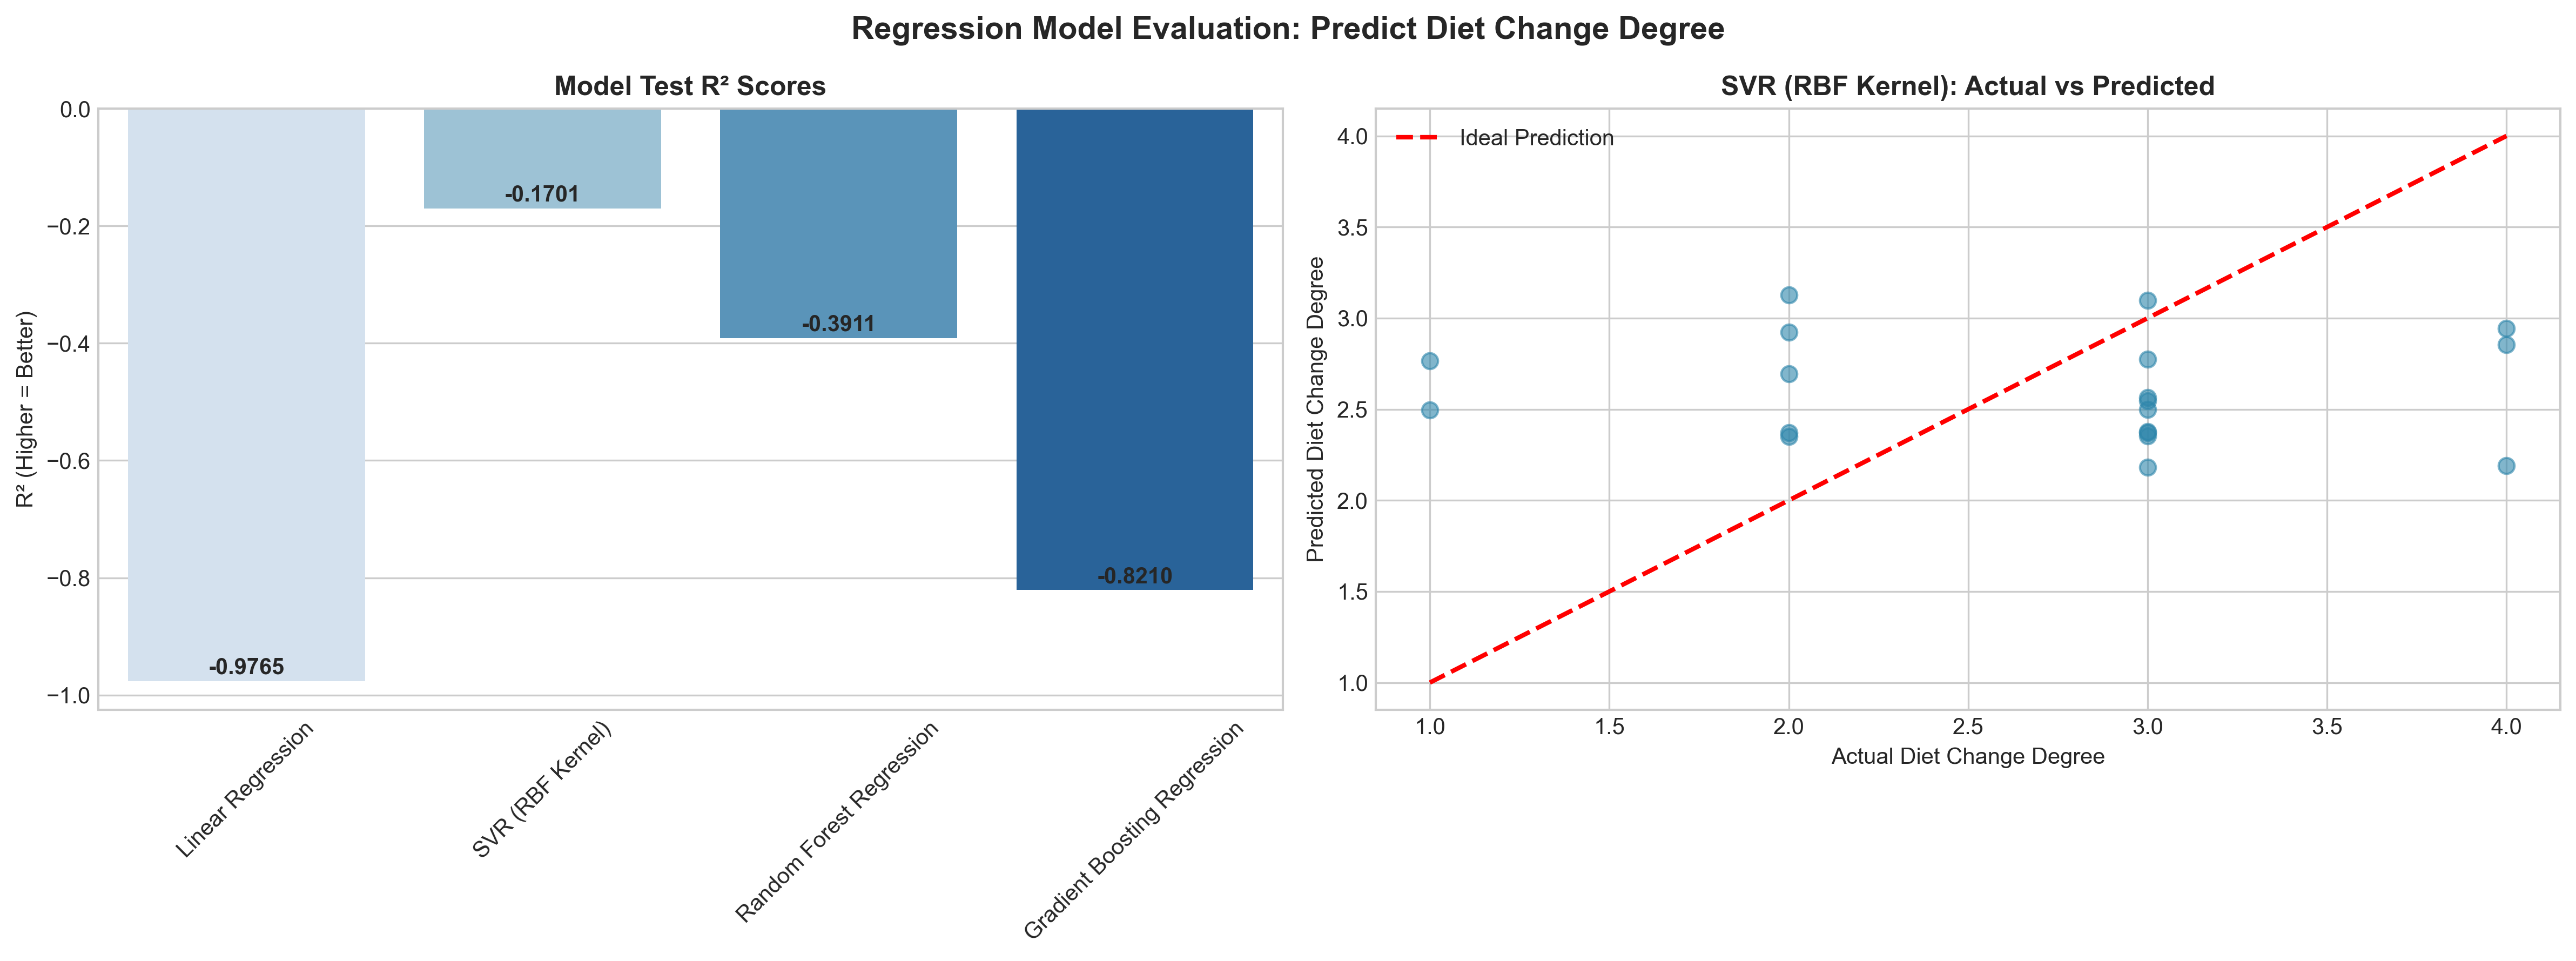

In [11]:
def train_regression_models(X_train, X_test, y_train, y_test):
    # Compare 4 regression models
    models = {
        'Linear Regression': LinearRegression(),
        'SVR (RBF Kernel)': SVR(kernel='rbf', C=1.0, gamma='scale'),
        'Random Forest Regression': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting Regression': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        cv_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
        
        results[name] = {'R²': r2, 'RMSE': rmse, 'CV R²': cv_r2, 'Predictions': y_pred, 'Model': model}
    
    # Print results
    print("\n=== Regression Model Performance ===")
    print(f"{'Model':<25} {'Test R²':<10} {'Test RMSE':<10} {'CV R²':<10}")
    print("-" * 60)
    for name, metrics in results.items():
        print(f"{name:<25} {metrics['R²']:<10.4f} {metrics['RMSE']:<10.4f} {metrics['CV R²']:<10.4f}")
    
    # Best model (highest R²)
    best_name = max(results.keys(), key=lambda x: results[x]['R²'])
    best_model = results[best_name]
    print(f"\nBest Regression Model: {best_name} (R²: {best_model['R²']:.4f})")
    
    # Plot evaluation
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Regression Model Evaluation: Predict Diet Change Degree', fontsize=14, fontweight='bold')
    
    # 1. Model R² Comparison
    model_names = list(results.keys())
    r2_scores = [results[name]['R²'] for name in model_names]
    sns.barplot(x=model_names, y=r2_scores, ax=axes[0], palette='Blues')
    axes[0].set_title('Model Test R² Scores', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('R² (Higher = Better)')
    axes[0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(r2_scores):
        axes[0].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Actual vs Predicted (Best Model)
    axes[1].scatter(y_test, best_model['Predictions'], alpha=0.6, color='#2E86AB', s=50)
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Ideal Prediction')
    axes[1].set_xlabel('Actual Diet Change Degree')
    axes[1].set_ylabel('Predicted Diet Change Degree')
    axes[1].set_title(f'{best_name}: Actual vs Predicted', fontsize=12, fontweight='bold')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return results, best_model

# Run regression modeling
reg_results, best_reg = train_regression_models(X_reg_train_scaled, X_reg_test_scaled, y_reg_train, y_reg_test)


=== Classification Model Performance ===
Model                     Test Acc   Test ROC-AUC CV Acc    
-----------------------------------------------------------------
Logistic Regression       0.8421     0.5833     0.8611    
SVC (RBF Kernel)          0.8421     0.5417     0.8611    
Random Forest Classifier  0.7895     0.7917     0.8611    
Gradient Boosting Classifier 0.8421     0.6042     0.7444    

Best Classification Model: Random Forest Classifier (ROC-AUC: 0.7917)


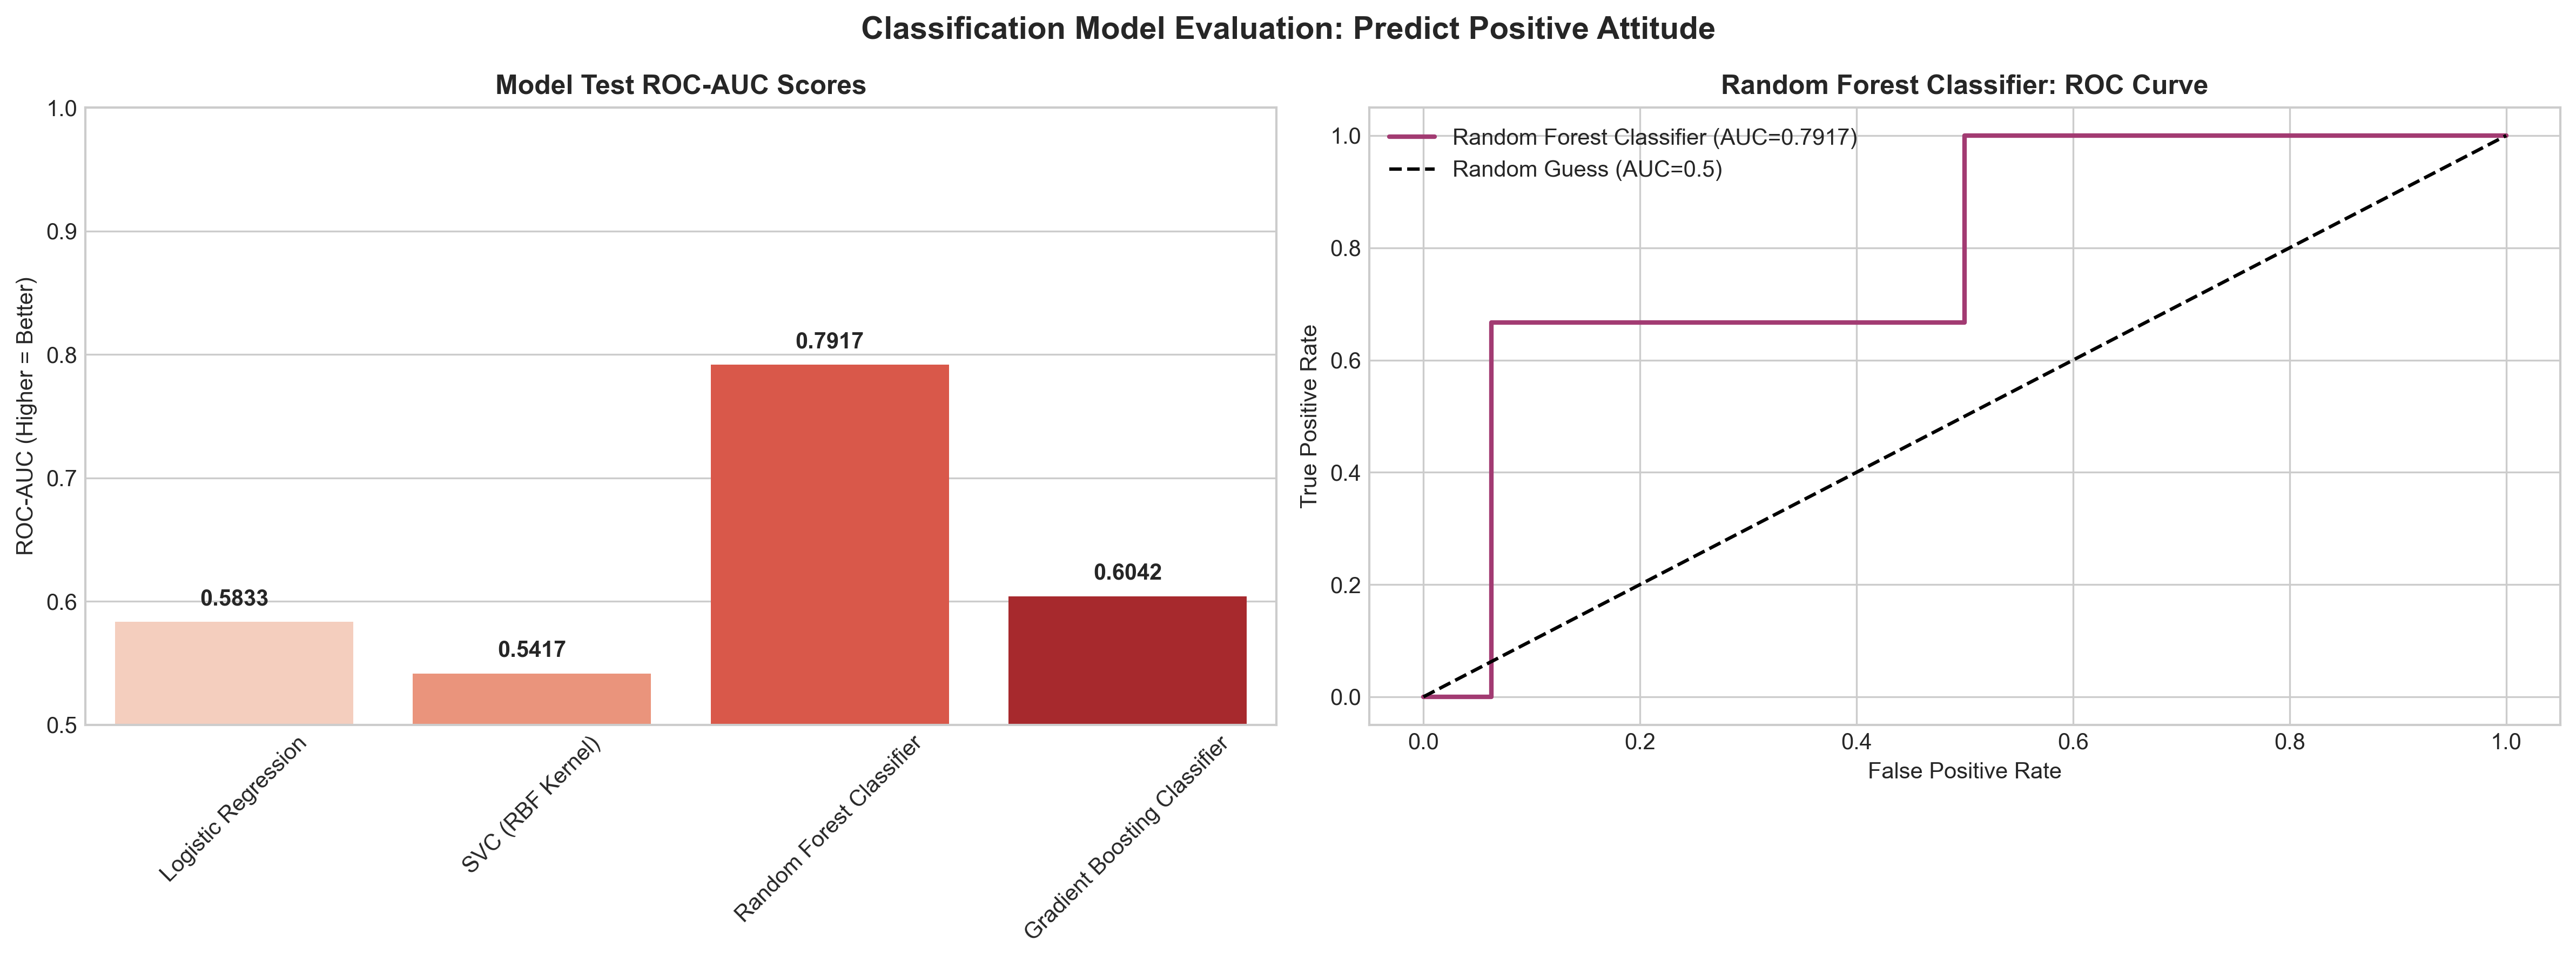

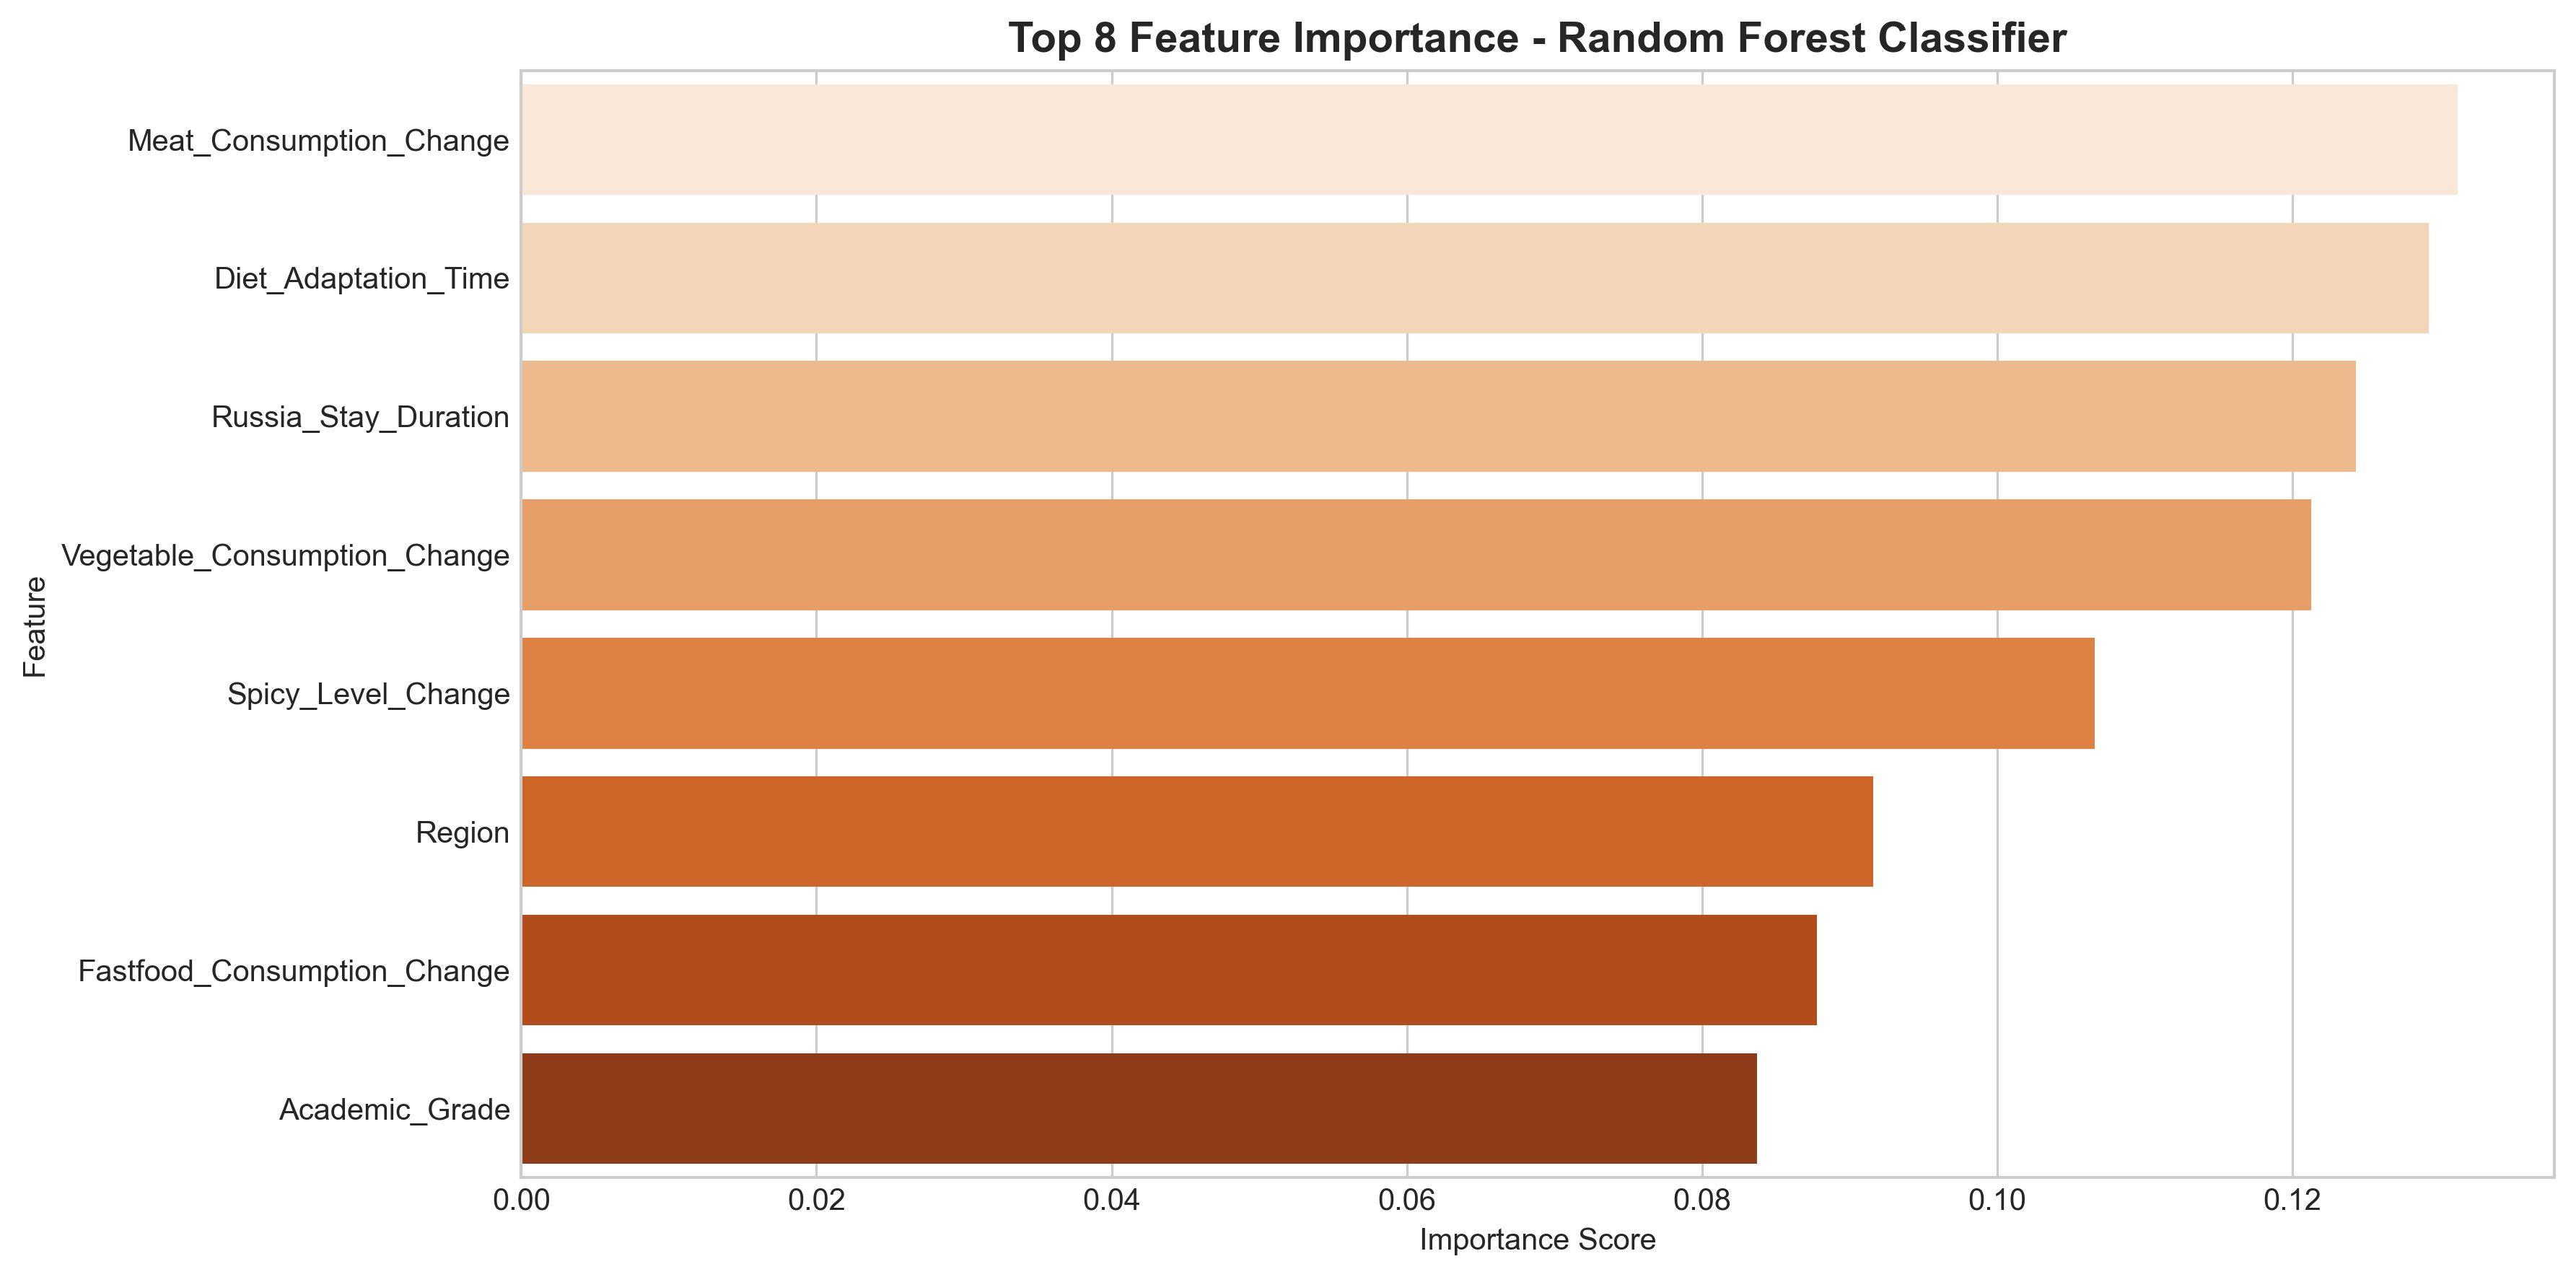

In [15]:
def train_classification_models(X_train, X_test, y_train, y_test):
    # Compare 4 classification models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'SVC (RBF Kernel)': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42),
        'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting Classifier': GradientBoostingClassifier(n_estimators=100, random_state=42)
    }
    
    results = {}
    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # Metrics
        acc = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        cv_acc = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
        
        results[name] = {'Accuracy': acc, 'ROC-AUC': roc_auc, 'CV Accuracy': cv_acc, 'Proba': y_proba, 'Model': model}
    
    # Print results
    print("\n=== Classification Model Performance ===")
    print(f"{'Model':<25} {'Test Acc':<10} {'Test ROC-AUC':<10} {'CV Acc':<10}")
    print("-" * 65)
    for name, metrics in results.items():
        print(f"{name:<25} {metrics['Accuracy']:<10.4f} {metrics['ROC-AUC']:<10.4f} {metrics['CV Accuracy']:<10.4f}")
    
    # Best model (highest ROC-AUC)
    best_name = max(results.keys(), key=lambda x: results[x]['ROC-AUC'])
    best_model = results[best_name]
    print(f"\nBest Classification Model: {best_name} (ROC-AUC: {best_model['ROC-AUC']:.4f})")
    
    # Plot evaluation
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Classification Model Evaluation: Predict Positive Attitude', fontsize=14, fontweight='bold')
    
    # 1. Model ROC-AUC Comparison
    model_names = list(results.keys())
    roc_scores = [results[name]['ROC-AUC'] for name in model_names]
    sns.barplot(x=model_names, y=roc_scores, ax=axes[0], palette='Reds')
    axes[0].set_title('Model Test ROC-AUC Scores', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('ROC-AUC (Higher = Better)')
    axes[0].set_ylim(0.5, 1.0)
    axes[0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(roc_scores):
        axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. ROC Curve (Best Model)
    fpr, tpr, _ = roc_curve(y_test, best_model['Proba'])
    axes[1].plot(fpr, tpr, color='#A23B72', linewidth=2, label=f'{best_name} (AUC={best_model["ROC-AUC"]:.4f})')
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC=0.5)')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'{best_name}: ROC Curve', fontsize=12, fontweight='bold')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Feature importance (for tree-based models)
    if best_name in ['Random Forest Classifier', 'Gradient Boosting Classifier']:
        importances = best_model['Model'].feature_importances_
        importance_df = pd.DataFrame({
            'Feature': feature_vars, 'Importance': importances
        }).sort_values('Importance', ascending=False).head(8)
        
        # Plot feature importance
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Oranges')
        ax.set_title(f'Top 8 Feature Importance - {best_name}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
    
    return results, best_model

# Run classification modeling
clf_results, best_clf = train_classification_models(X_clf_train_scaled, X_clf_test_scaled, y_clf_train, y_clf_test)

Starting Chinese Students' Dietary Habit Analysis (Russia)

Step 1: Data loading and preprocessing done.

Step 2: Generating visualizations...


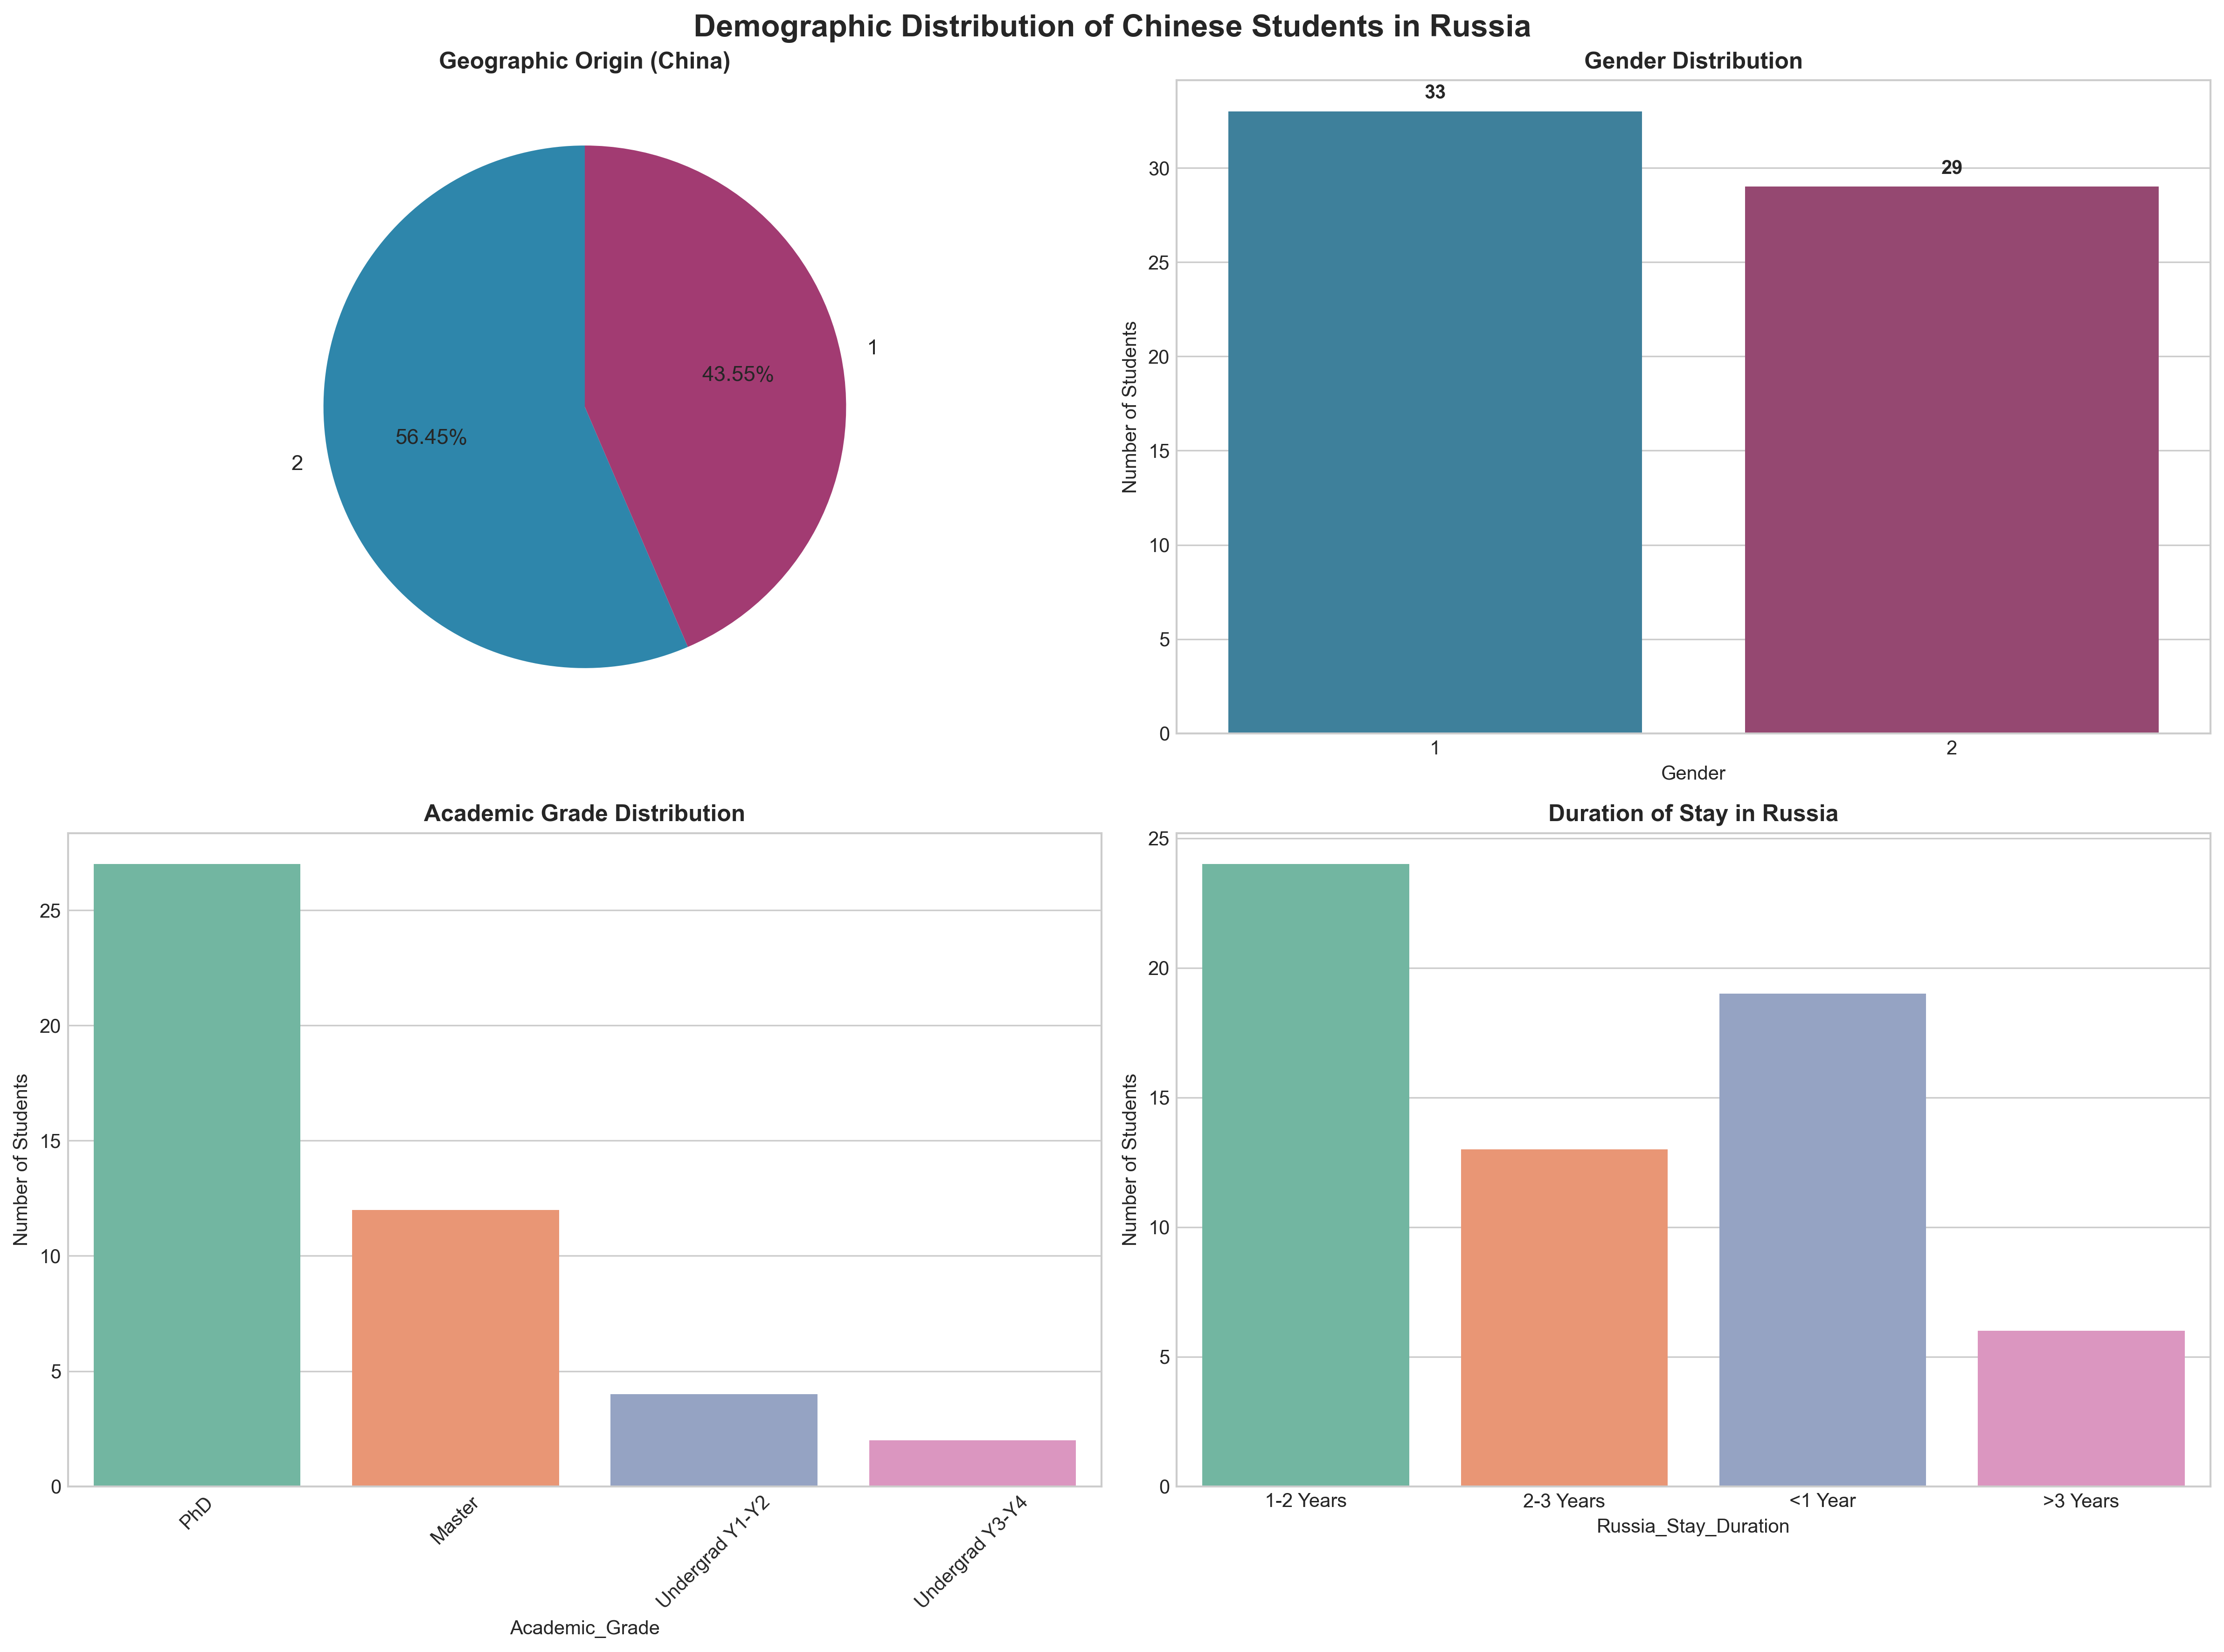

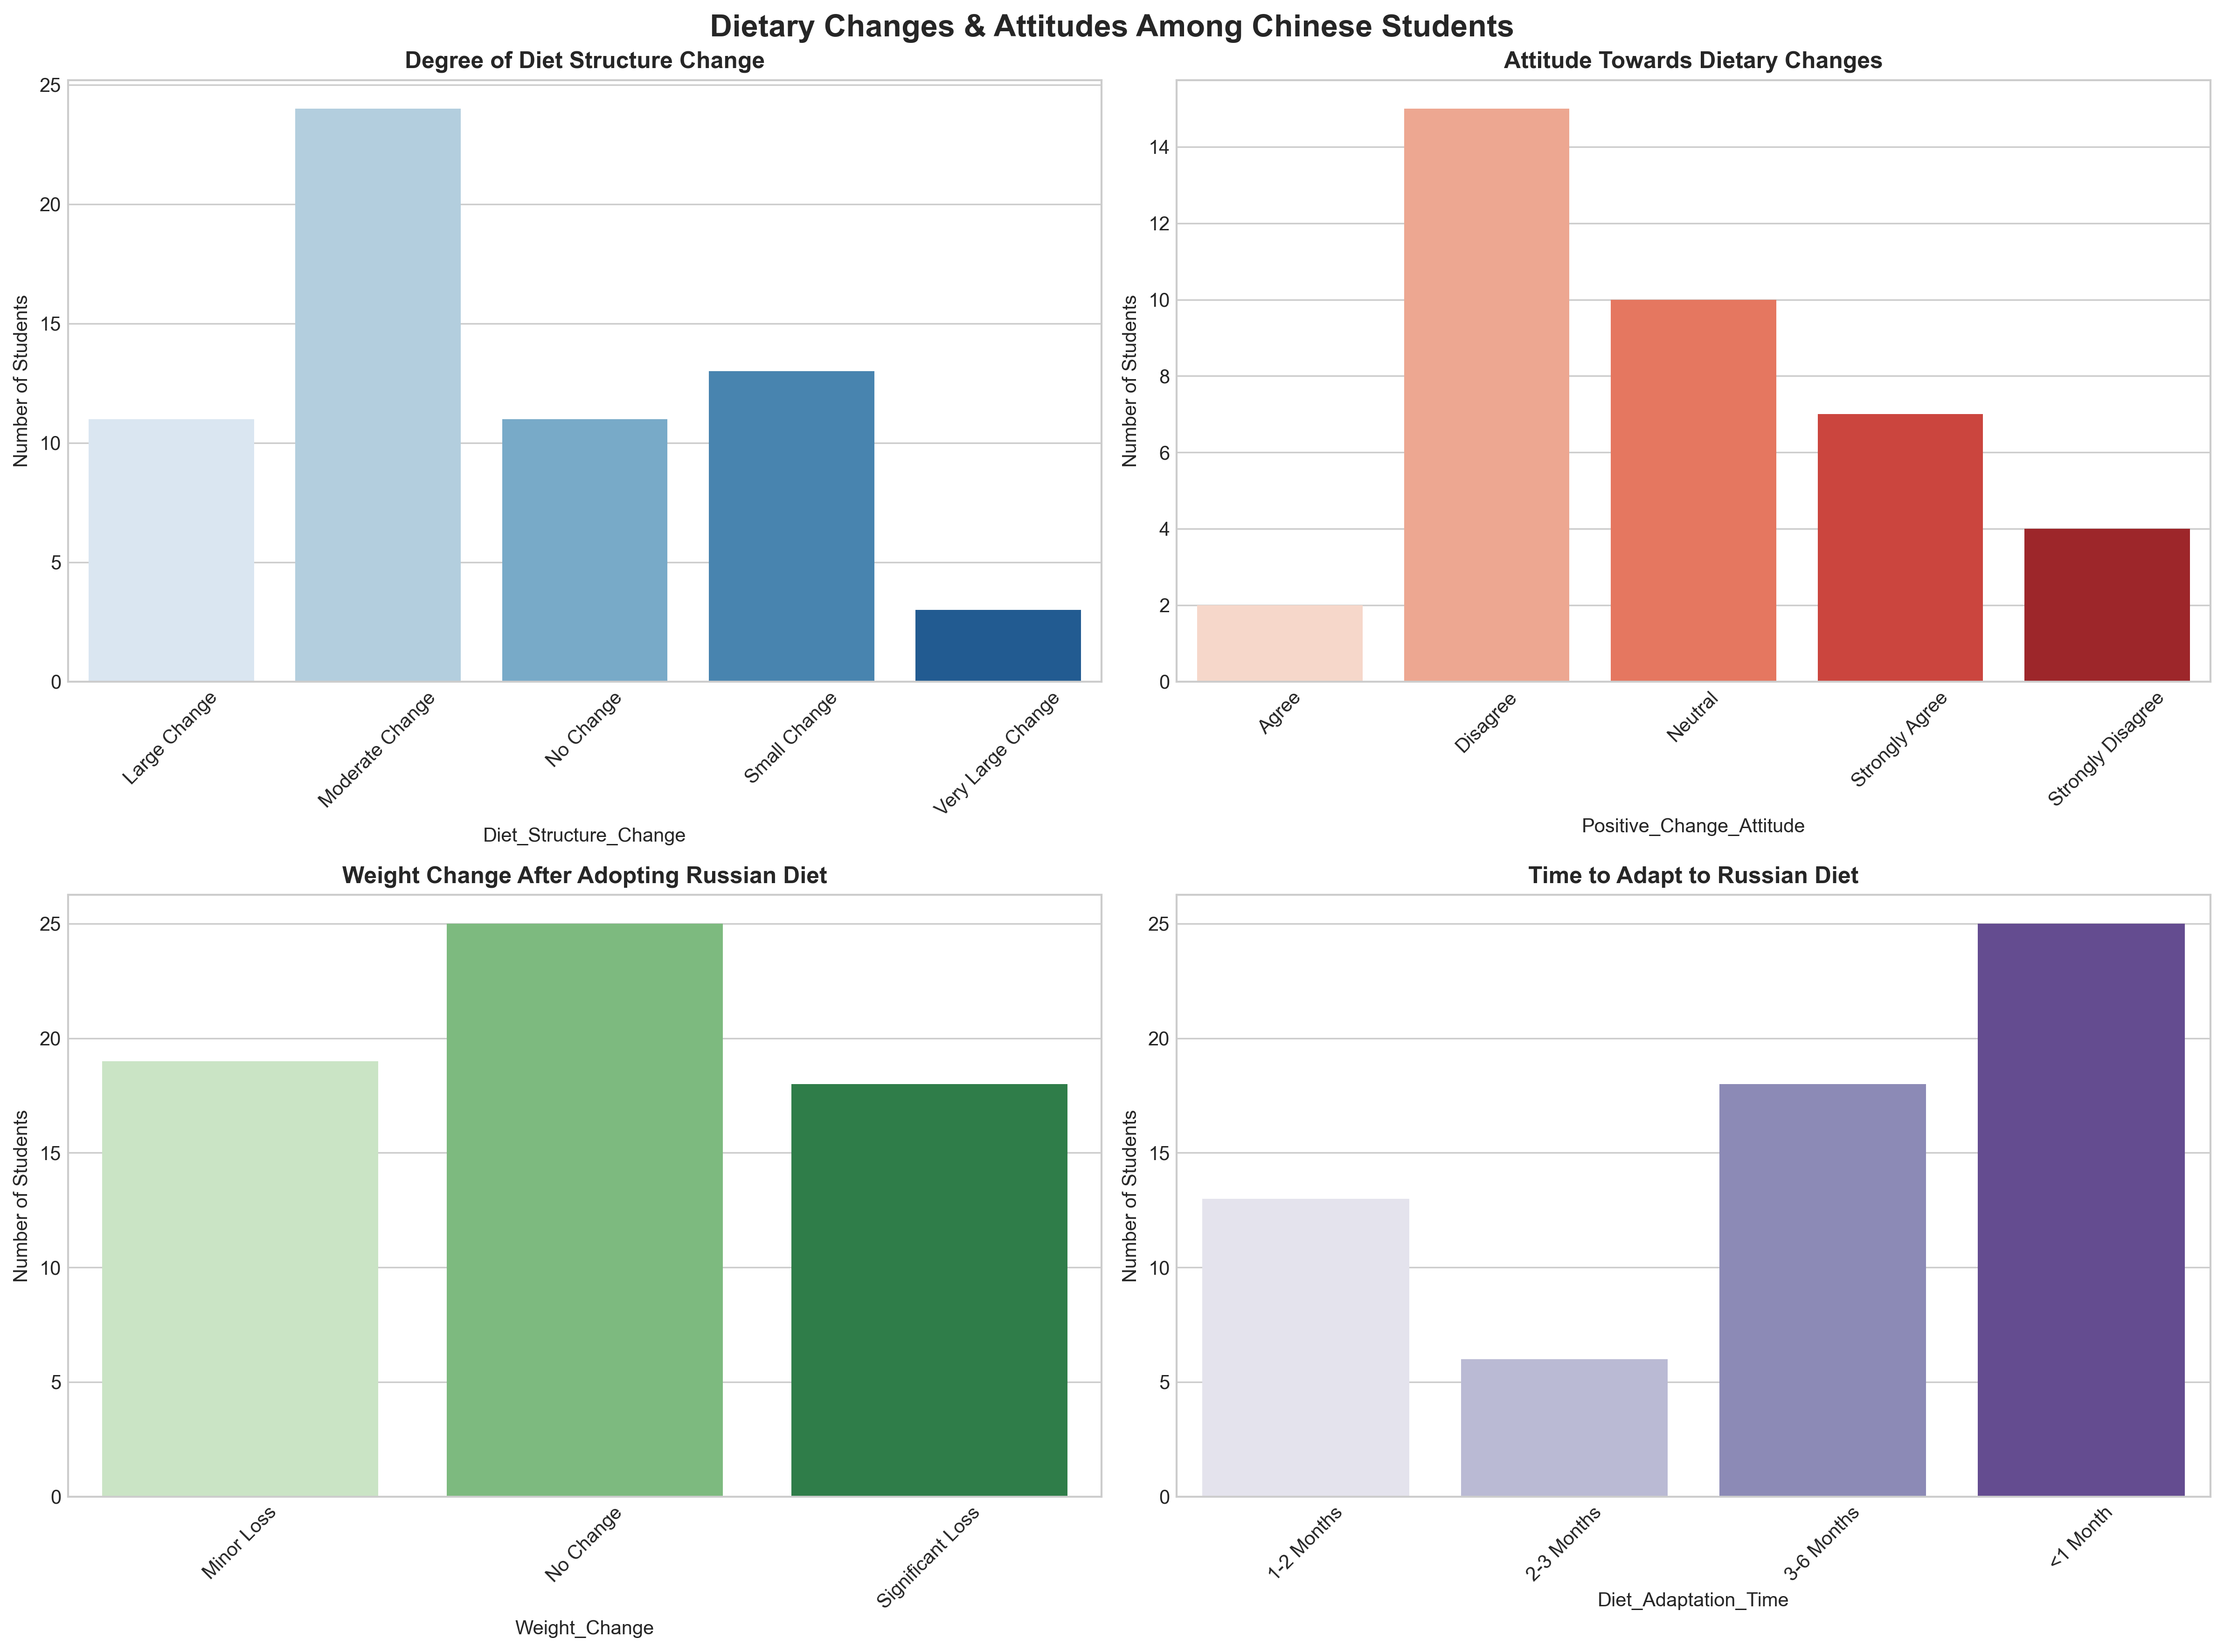

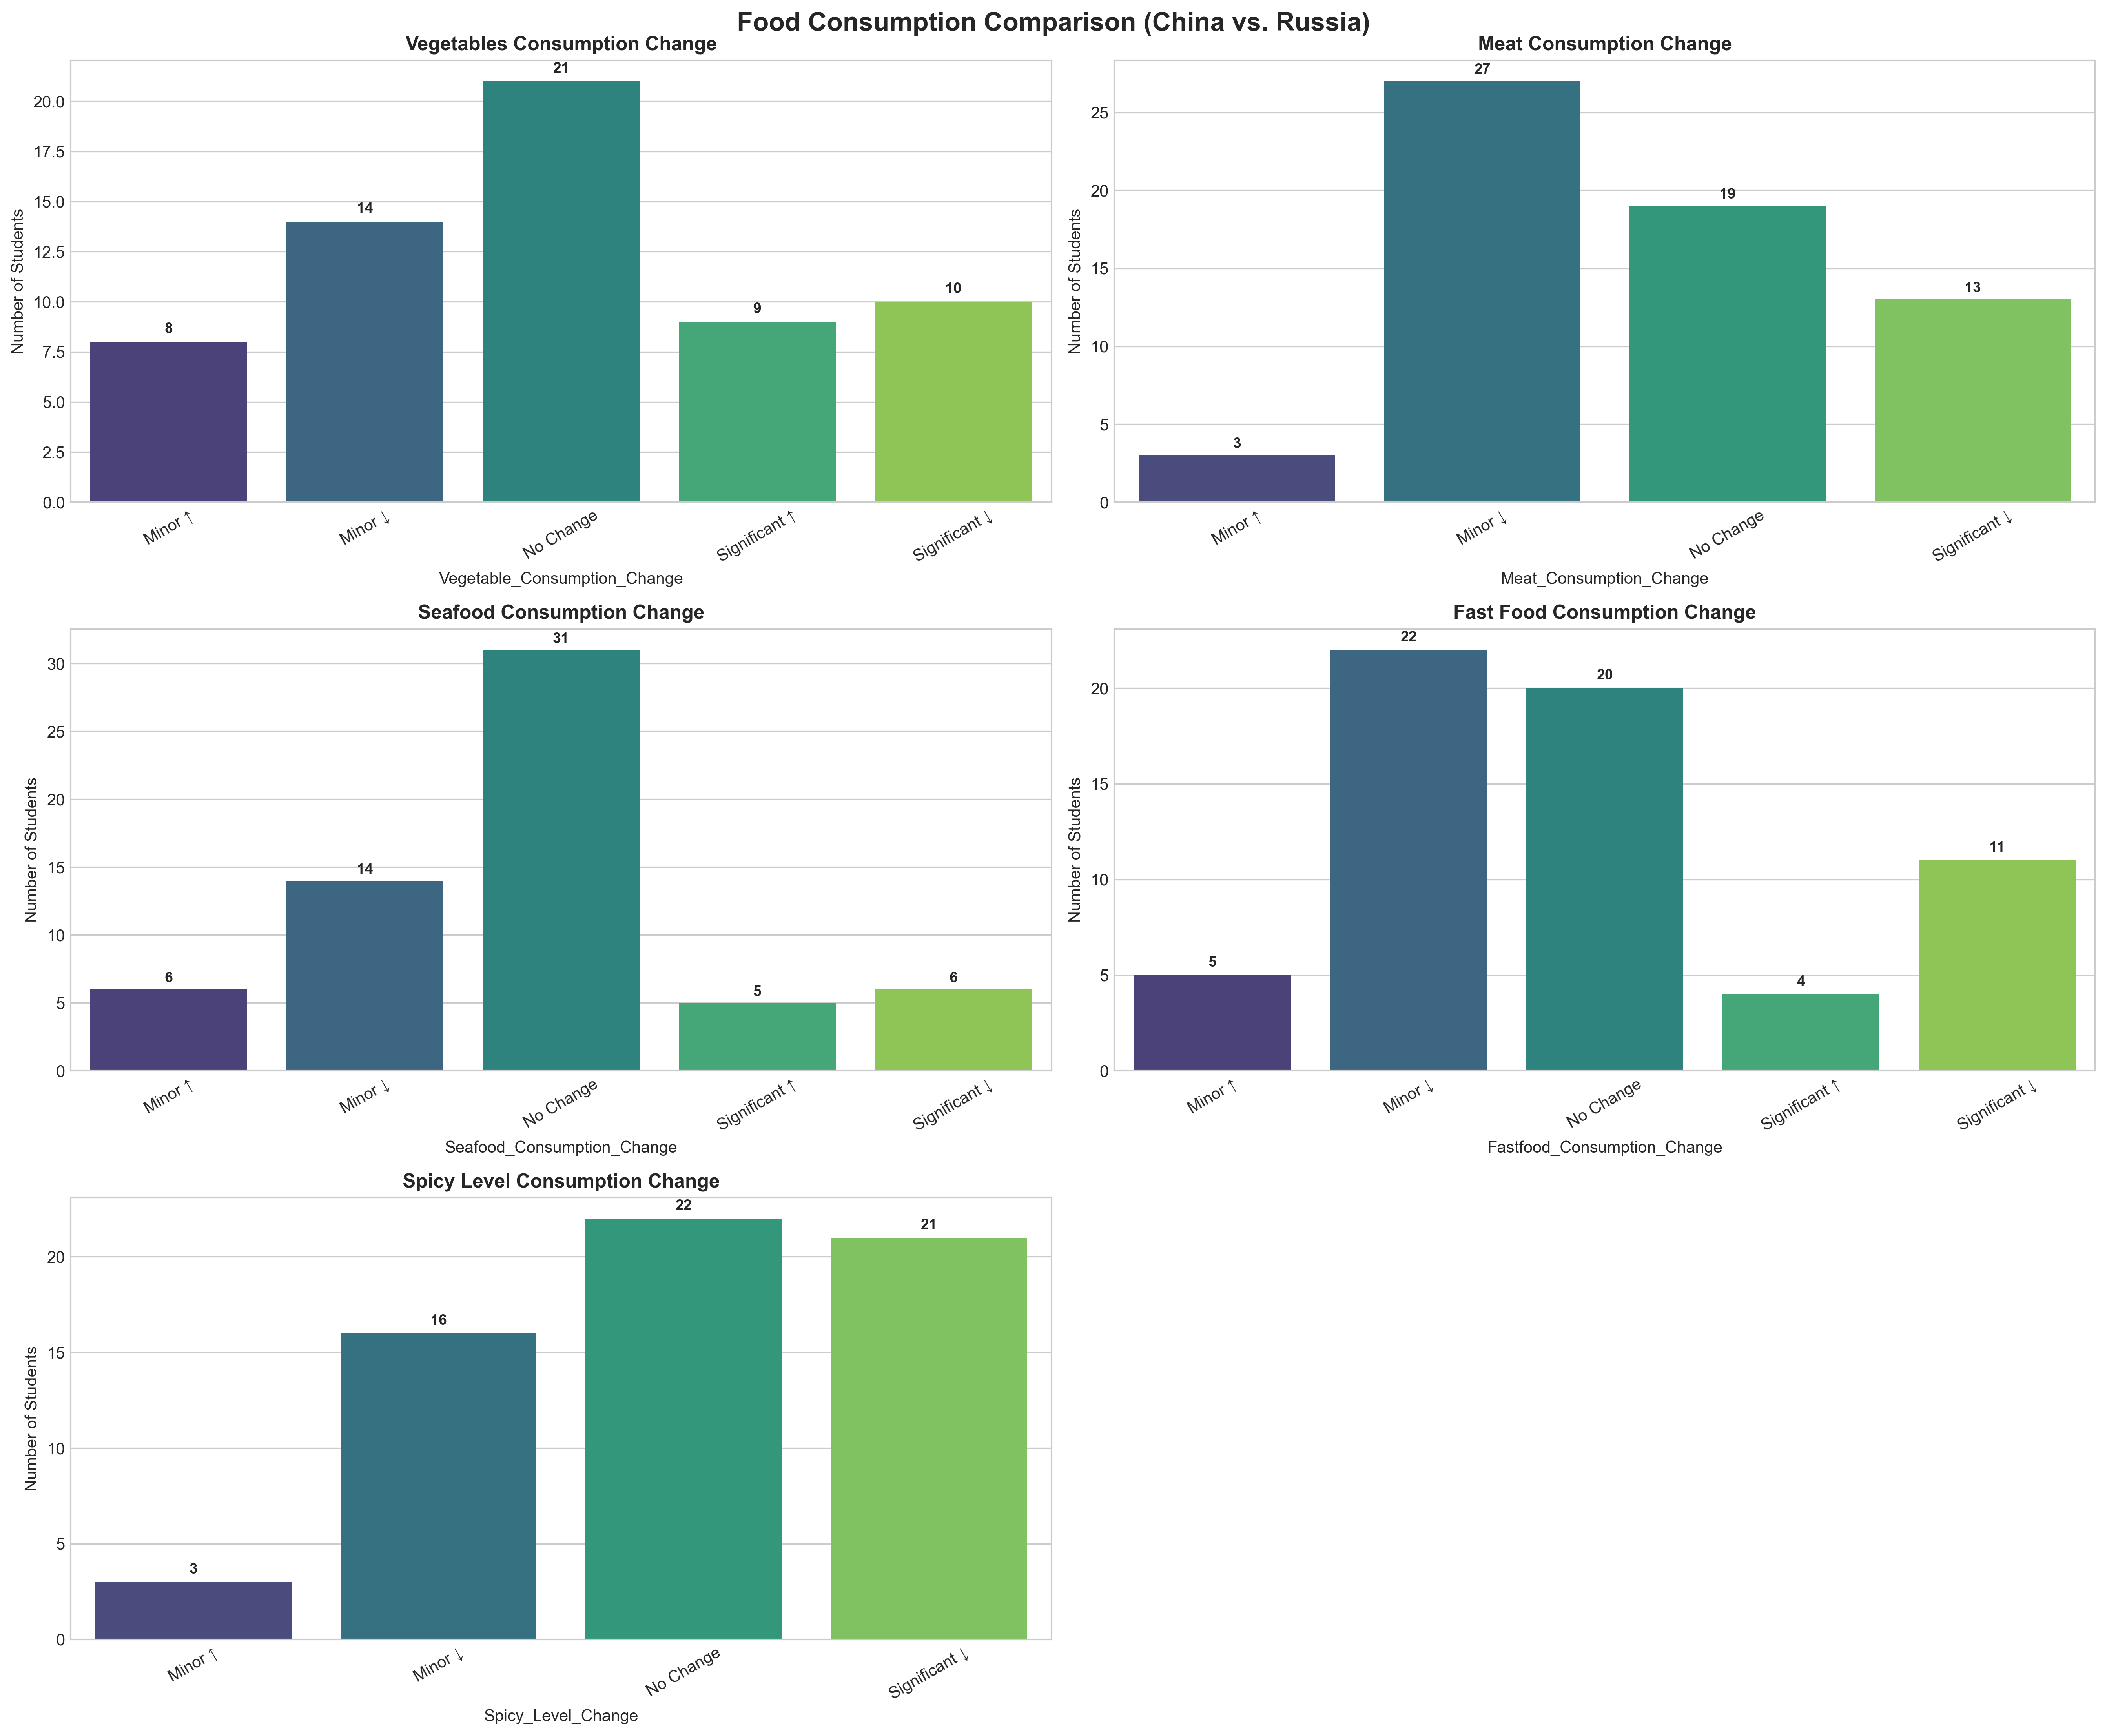

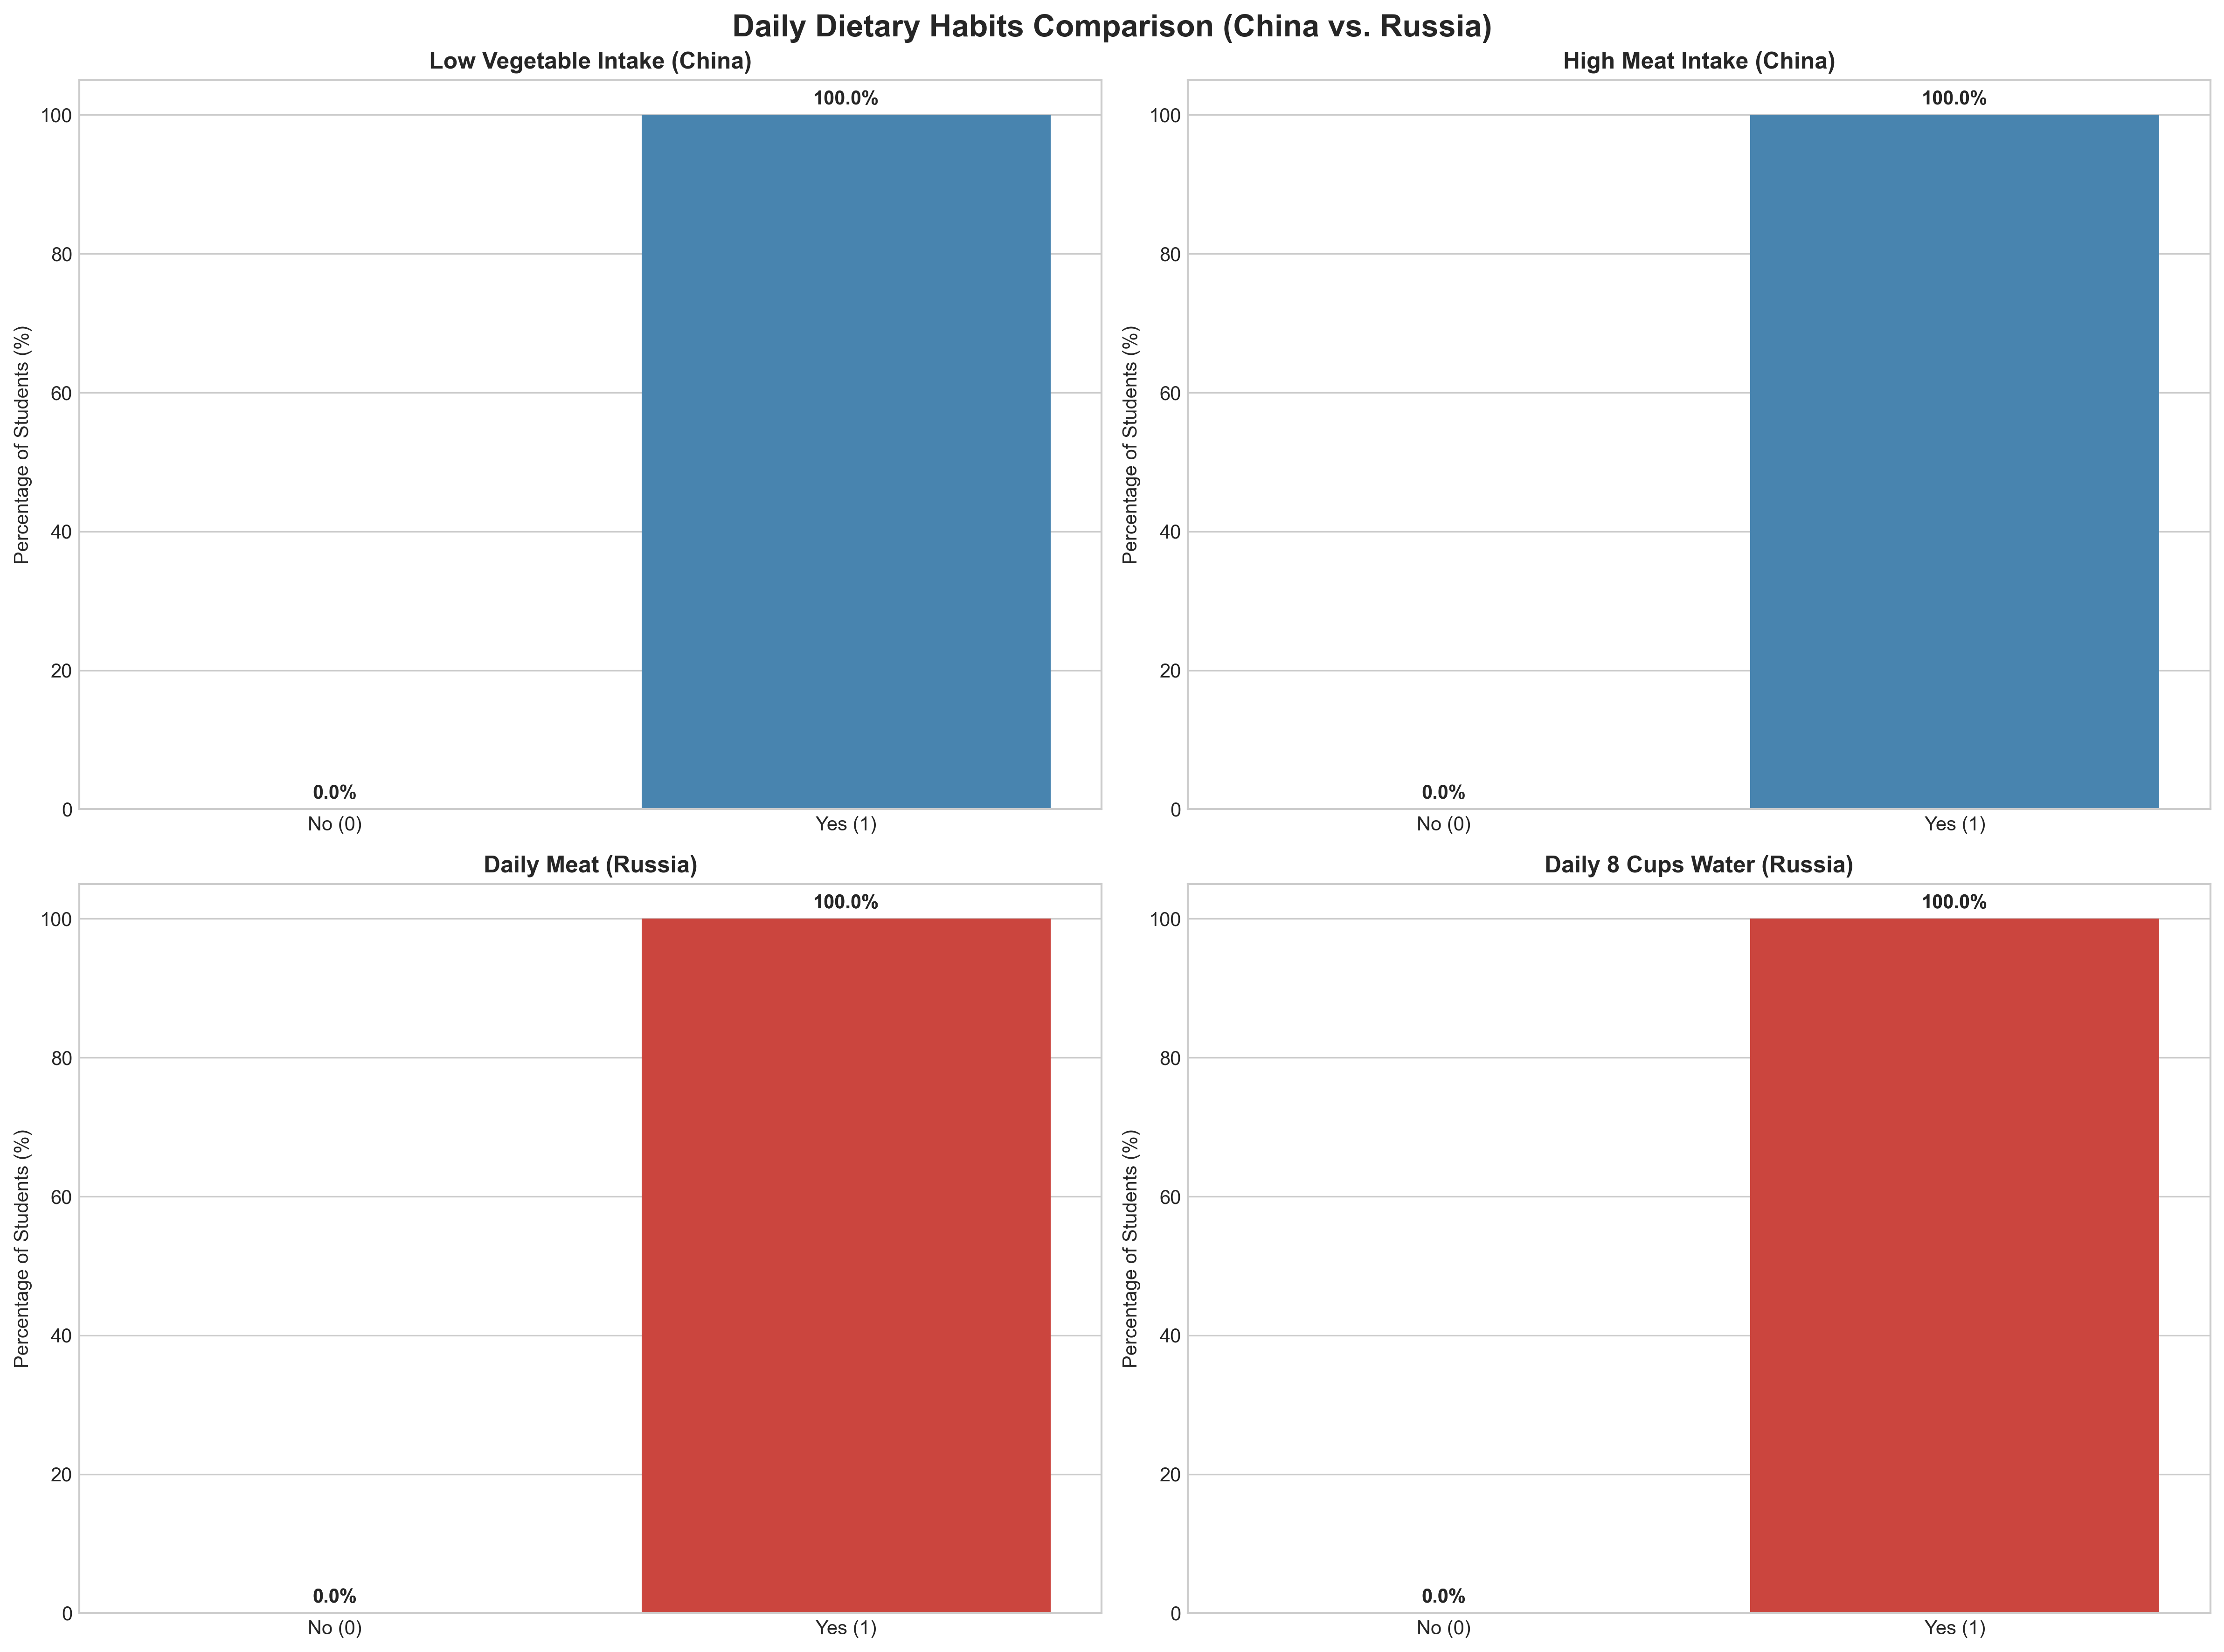

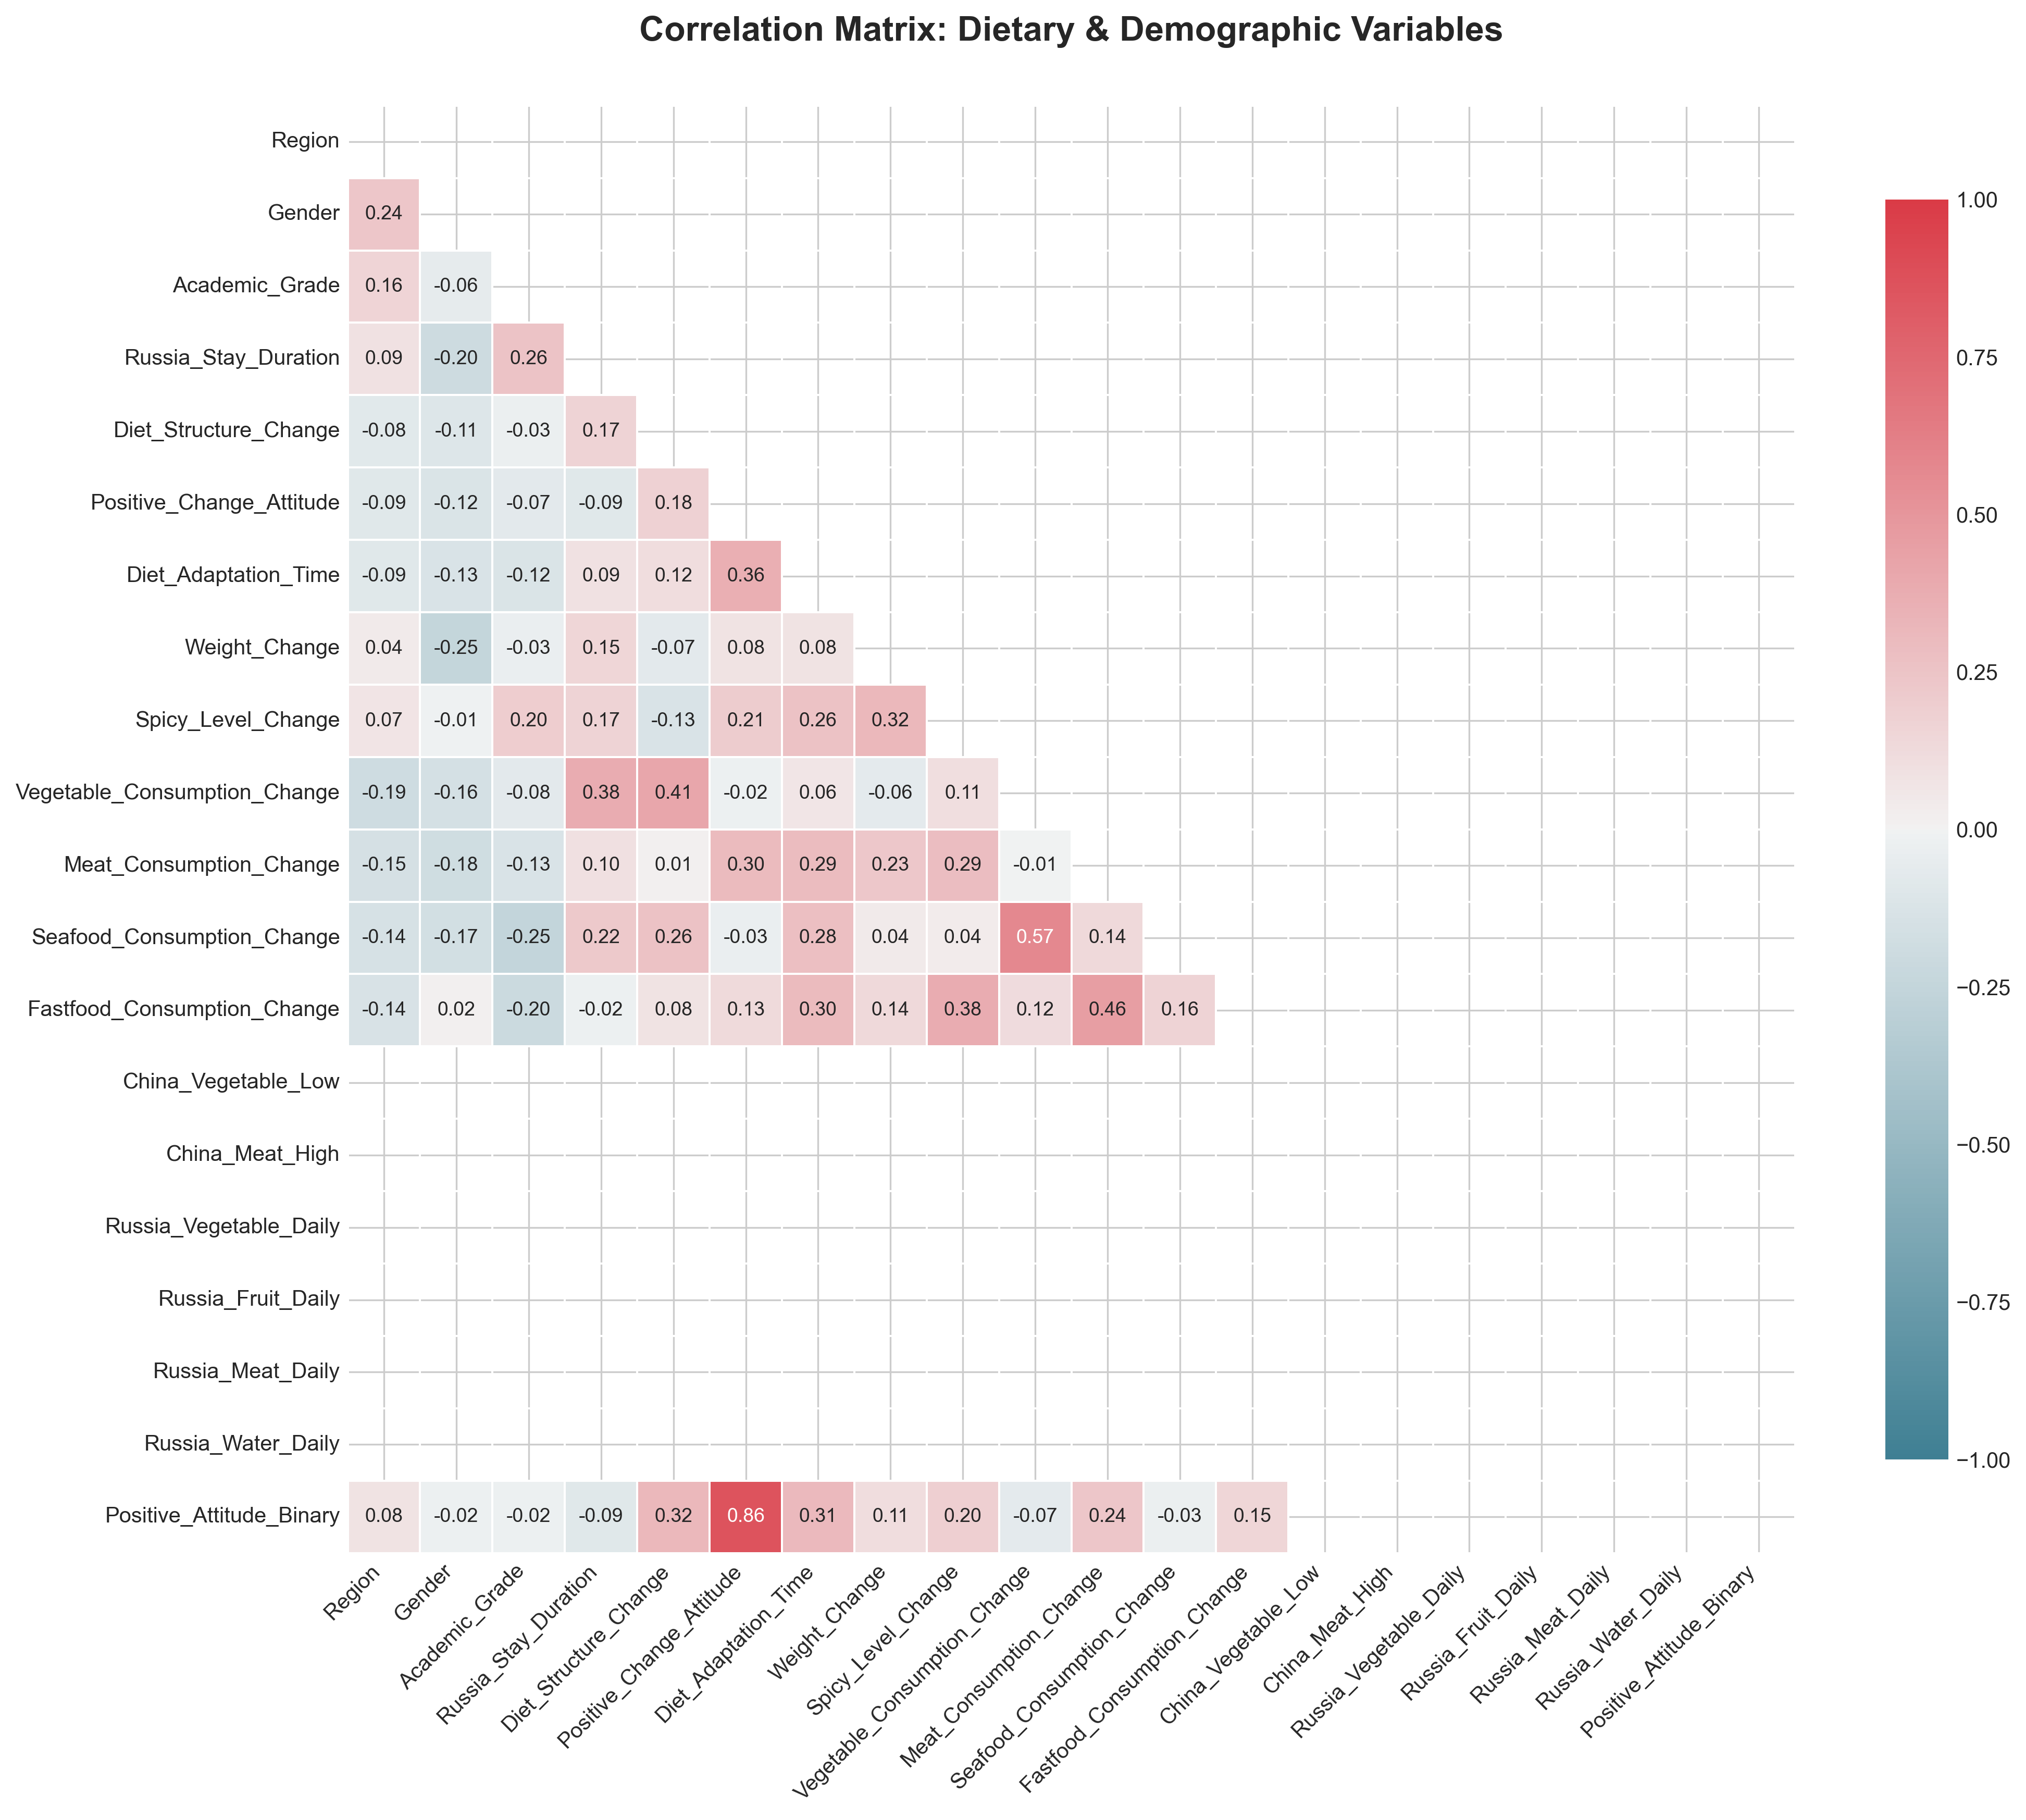


Step 3: Training predictive models...

=== Regression Model Performance ===
Model                     Test R²    Test RMSE  CV R²     
------------------------------------------------------------
Linear Regression         -0.9765    1.2113     -0.5427   
SVR (RBF Kernel)          -0.1701    0.9320     -0.4269   
Random Forest Regression  -0.3911    1.0162     -0.2701   
Gradient Boosting Regression -0.8210    1.1627     -1.2980   

Best Regression Model: SVR (RBF Kernel) (R²: -0.1701)


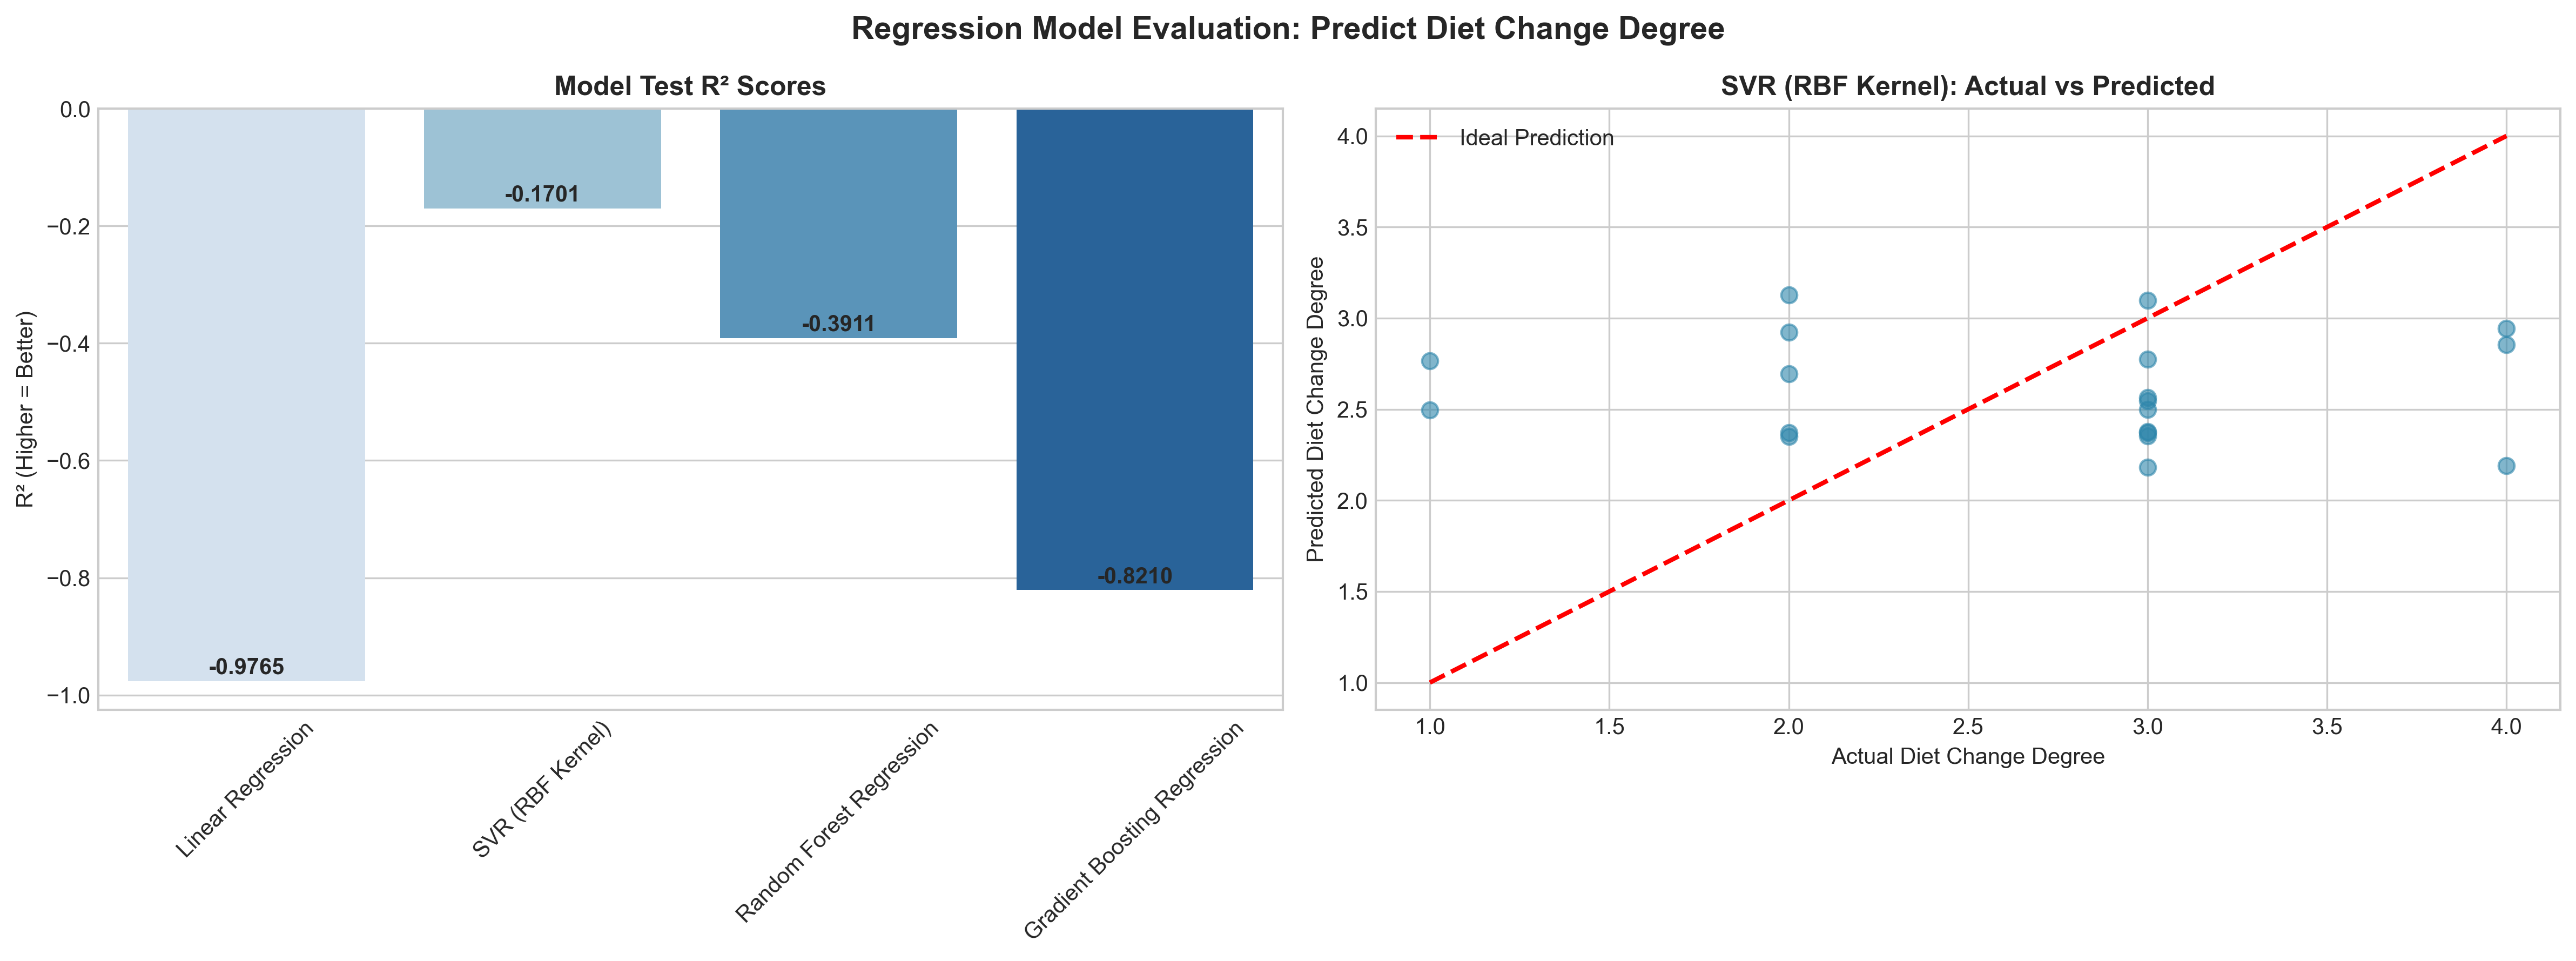


=== Classification Model Performance ===
Model                     Test Acc   Test ROC-AUC CV Acc    
-----------------------------------------------------------------
Logistic Regression       0.8421     0.5833     0.8611    
SVC (RBF Kernel)          0.8421     0.5417     0.8611    
Random Forest Classifier  0.7895     0.7917     0.8611    
Gradient Boosting Classifier 0.8421     0.6042     0.7444    

Best Classification Model: Random Forest Classifier (ROC-AUC: 0.7917)


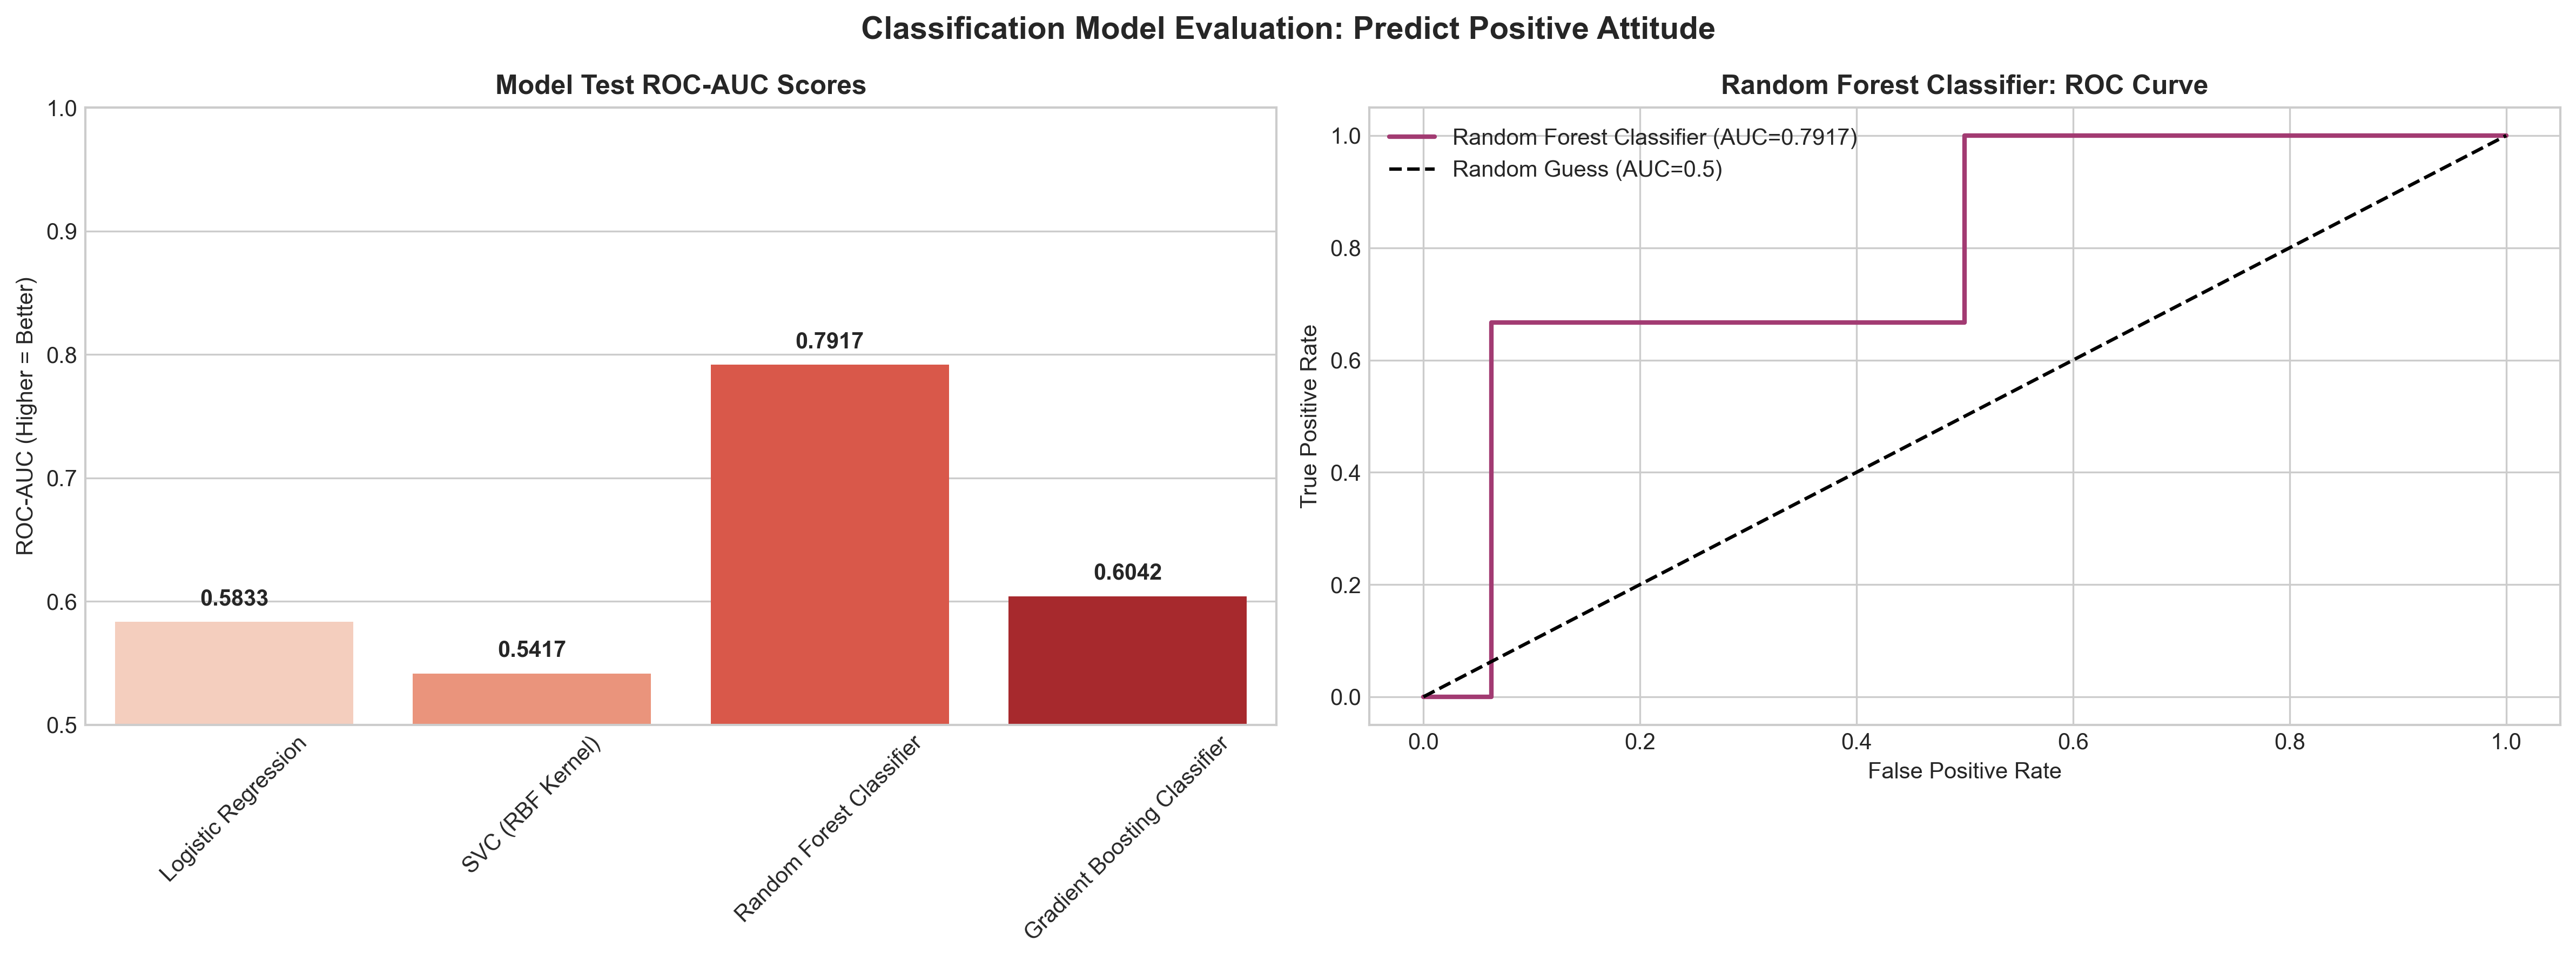

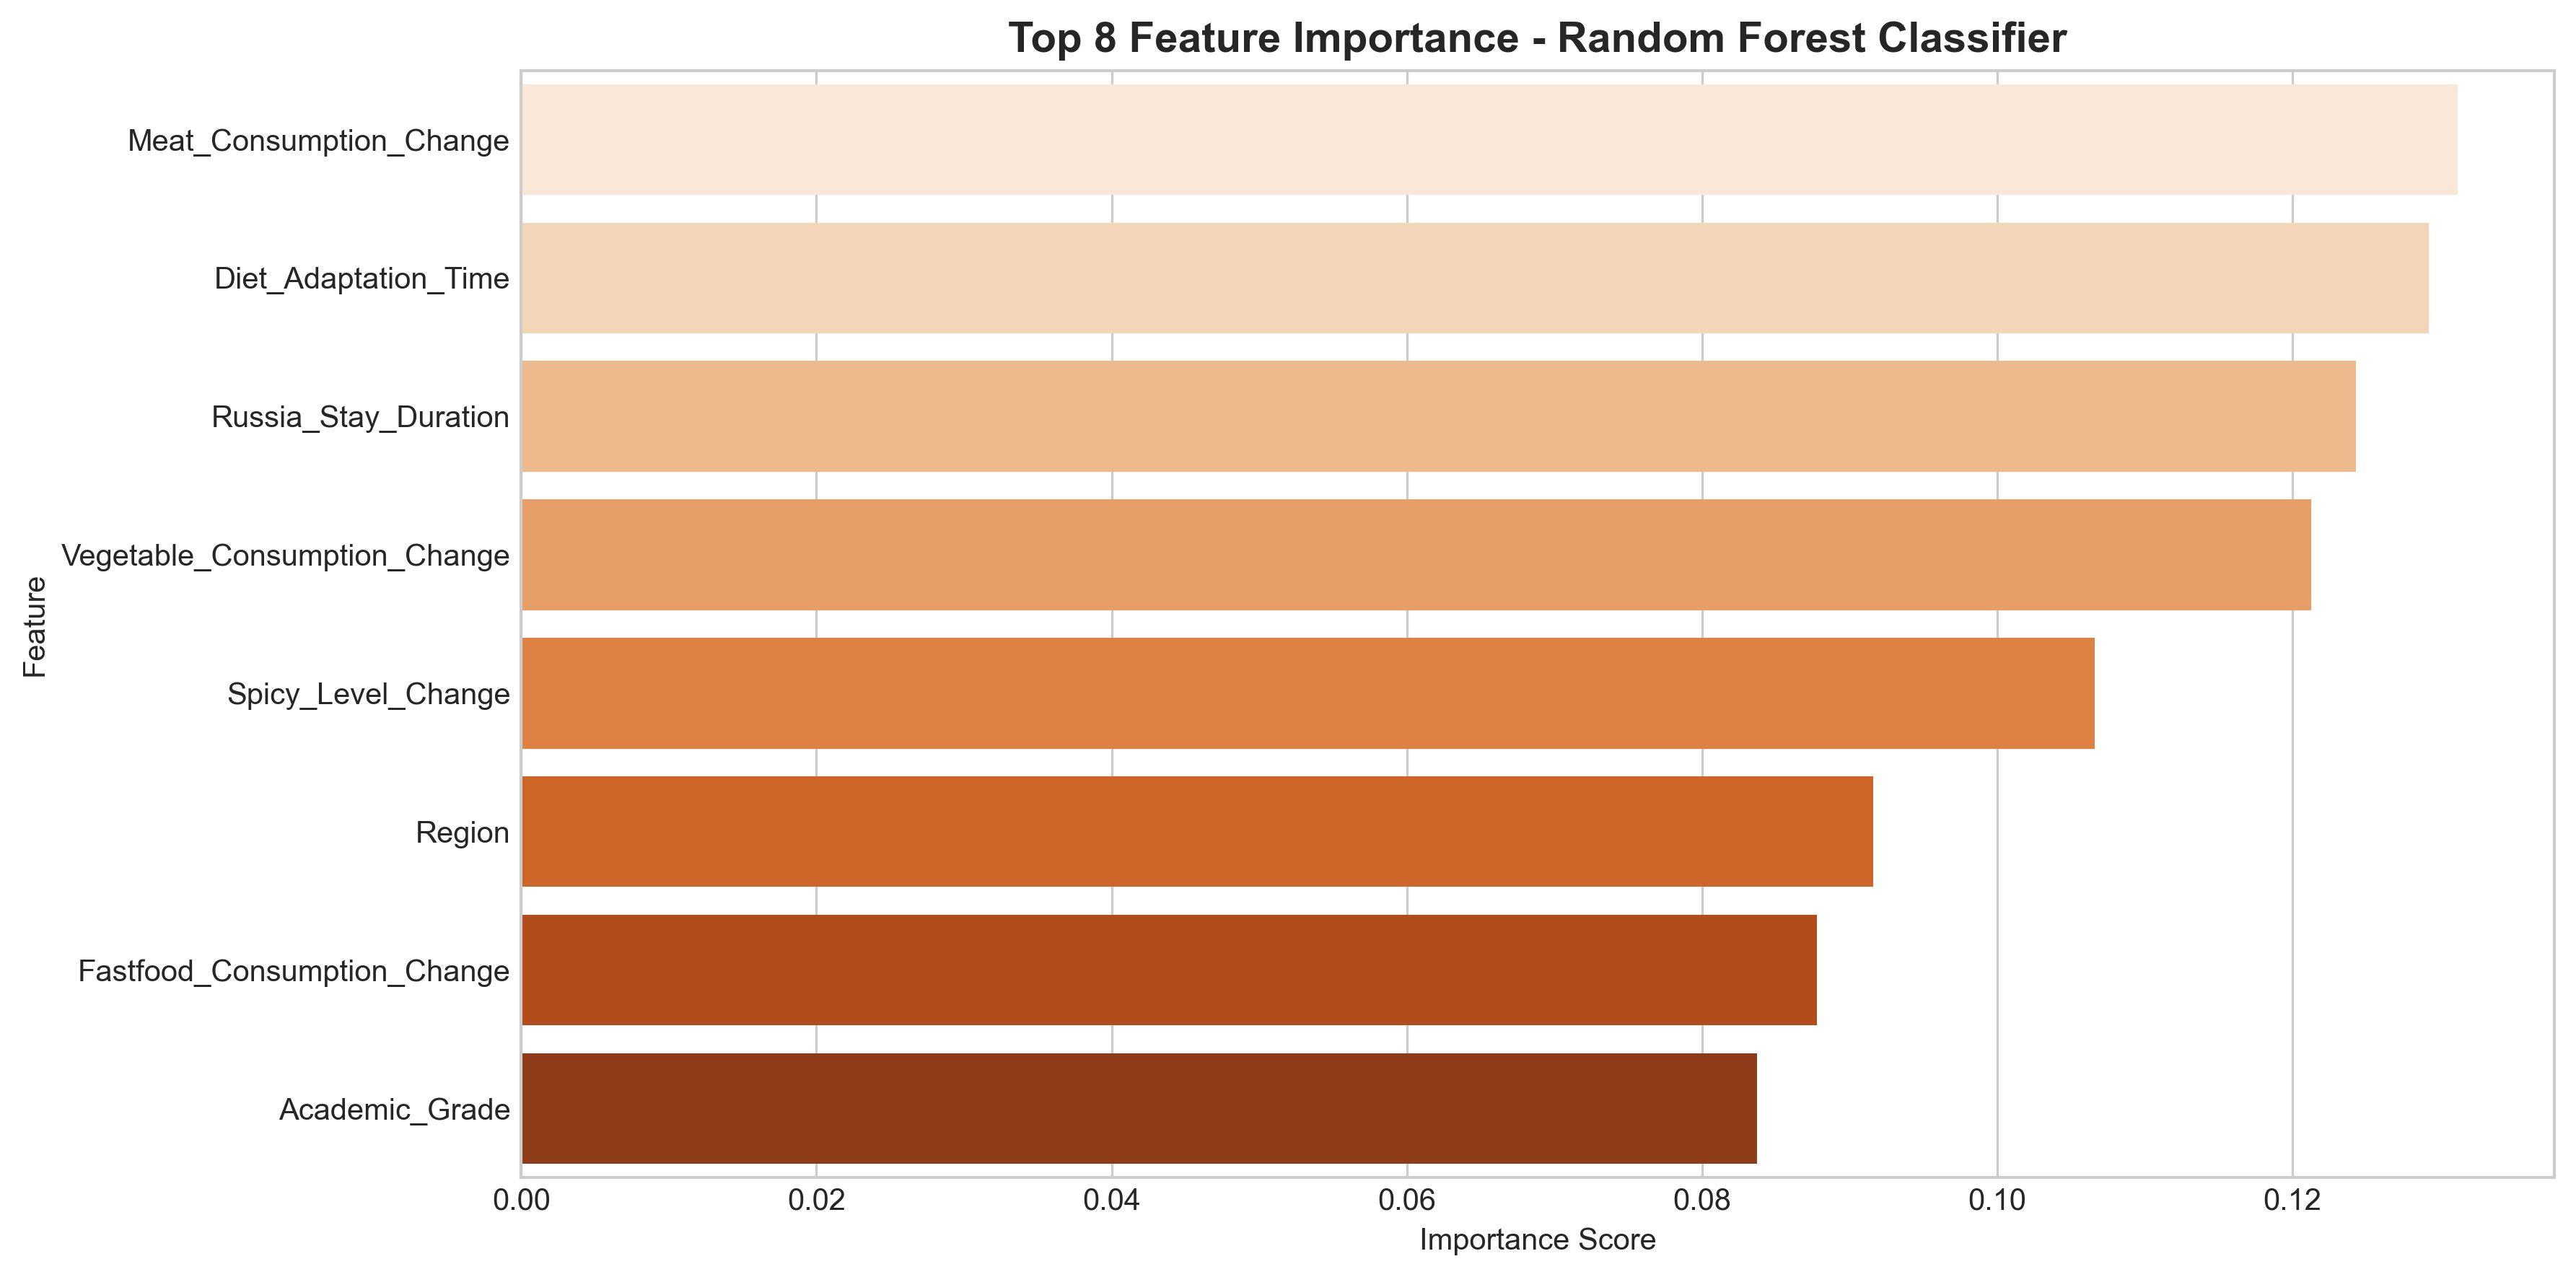


All Analysis Completed Successfully!
Visualizations and models are ready for your final assignment.


In [16]:
if __name__ == "__main__":
    print("=" * 80)
    print("Starting Chinese Students' Dietary Habit Analysis (Russia)")
    print("=" * 80)
    
    # Step 1: Data Loading & Preprocessing (Completed in Sections 2-3)
    print("\nStep 1: Data loading and preprocessing done.")
    
    # Step 2: Generate All Visualizations
    print("\nStep 2: Generating visualizations...")
    plot_demographics(data_final)
    plot_dietary_changes(data_final)
    plot_consumption_comparison(data_final)
    plot_habits_comparison(data_final)
    plot_correlation_matrix(data_final)
    
    # Step 3: Train Predictive Models
    print("\nStep 3: Training predictive models...")
    reg_results, best_reg = train_regression_models(X_reg_train_scaled, X_reg_test_scaled, y_reg_train, y_reg_test)
    clf_results, best_clf = train_classification_models(X_clf_train_scaled, X_clf_test_scaled, y_clf_train, y_clf_test)
    
    print("\n" + "=" * 80)
    print("All Analysis Completed Successfully!")
    print("Visualizations and models are ready for your final assignment.")
    print("=" * 80)